In [2]:
import time
import sys
sys.path.append('../')
import librairies.dagfeaturingfx 
from  librairies.dagfeaturingfx import *
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
from joblib import Parallel,delayed
import pyttsx3
from sklearn.preprocessing import MinMaxScaler
from librairies.bt import *
scaler = MinMaxScaler(feature_range=(0, 1))
engine = pyttsx3.init()
engine.say("Librairies loaded")
engine.runAndWait()

Importing Librairies...


In [3]:
###### RELOAD LIBRAIRIE #####
from importlib import reload
sys.path.append('../')
librairies.dagfeaturingfx= reload(librairies.dagfeaturingfx)
from  librairies.dagfeaturingfx import *

In [4]:
####### CHOIX DE LA TIME FRAME
_period = 'm15'

In [5]:
%%time
##### Récupération de la liste des tickers à partir du répertoire où sont rangées les bases
TICKER_LIST = get_ticker_list()



Récupération des tickers
CPU times: user 1.03 ms, sys: 1.16 ms, total: 2.2 ms
Wall time: 1.26 ms


In [4]:
%%time
engine.say("Processing featuring of dataframes, weekly, daily and intra-day")
engine.runAndWait()
##### Récupération des data pour tous les tickers sur la période demandée en intraday => df_all
df_all = get_all_data(TICKER_LIST,_period=_period)
engine.say("The job is done")
engine.runAndWait()

KeyboardInterrupt: 

In [4]:
%%time
##### Si la période demandée est déjà H1, on peut construire directement la base daily pour tous les tickers => daily_all
if _period == 'H1':
    df_all = timerange1D(df_all)
    daily_all = get_daily(df_all,TICKER_LIST)

##### Si la période n'est pas H1, on récupère d'abord les data en 1H pour tous les tickers, et on construit la base daily à partir du 1H => daily_all
else:
    df_all = timerange1D(df_all)
    hourly_all = get_all_data(TICKER_LIST,_period='H1')
    hourly_all = timerange1D(hourly_all)
    daily_all = get_daily(hourly_all,TICKER_LIST)
    del hourly_all
engine.say("The job is done")
engine.runAndWait()


Ajout Date
100%|██████████| 42/42 [00:00<00:00, 141041.45it/s]
Récupération des data intraday


Ajout Date
100%|██████████| 42/42 [00:00<00:00, 129339.77it/s]
Récupération des data daily

CPU times: user 1min 40s, sys: 3.74 s, total: 1min 44s
Wall time: 2min 21s


In [5]:
%%time
##### A partir de la base daily_all on construit la base weekly pour tous les tickers => weekly_all
daily_all = timerange1W(daily_all)
weekly_all = get_weekly(daily_all,TICKER_LIST)
engine.say("The job is done")
engine.runAndWait()


Ajout colonne 'Date dans le weekly
100%|██████████| 42/42 [00:00<00:00, 227011.30it/s]
Récupération des tickers weekly

CPU times: user 4.93 s, sys: 462 ms, total: 5.39 s
Wall time: 10.3 s


In [6]:
%%time
##### On calcule l'ADR sur le daily
daily_all = adr(daily_all,_window=14)
engine.say("The job is done")
engine.runAndWait()

 14%|█▍        | 6/42 [00:00<00:00, 52.72it/s]
Calcul du ADR
100%|██████████| 42/42 [00:01<00:00, 40.11it/s]
CPU times: user 1.03 s, sys: 53.7 ms, total: 1.08 s
Wall time: 4.07 s


In [7]:
%%time
##### On récupère l'ADR qui a été calculé en daily (daily_all) pour le mettre dans la base intraday df_all
df_all = getadr(daily_all,df_all,TICKER_LIST)

100%|██████████| 42/42 [00:00<00:00, 137303.79it/s]
Récupération de l'ADR en cours...

CPU times: user 2min 32s, sys: 17.2 s, total: 2min 49s
Wall time: 4min 39s


In [8]:
%%time
##### On calcule l'ADR High & Low dans notre base intraday df_all
df_all = adrhnl(daily_all,df_all,TICKER_LIST)


Calcul du ADR High & Low
En cours...
100%|██████████| 42/42 [00:00<00:00, 147909.96it/s]
CPU times: user 30.5 s, sys: 22.4 s, total: 52.9 s
Wall time: 2min 53s


In [9]:
%%time
##### Calcul d'une SMA 200 sur df_all
df_all = sma(df_all=df_all,_window=200)


Calcul SMA
CPU times: user 3.75 s, sys: 668 ms, total: 4.42 s
Wall time: 4.42 s


In [10]:
%%time
##### Calcul des bollinger sur df_all
df_all = bollinger(df_all,_slow=20)


Calcul BOLLINGER
CPU times: user 8.76 s, sys: 2.43 s, total: 11.2 s
Wall time: 10.9 s


In [11]:
%%time
##### Calcul du stochastic slow. Par défaut les paramètres sont 5 et 3.
df_all = slowstochastic(df_all,TICKER_LIST)

100%|██████████| 42/42 [00:00<00:00, 106634.85it/s]
Calcul du Slow STOCHASTIC
Fenêtre de Glissement : 5 periodes.
Période de lissage : 3 periodes.

CPU times: user 22.9 s, sys: 18.4 s, total: 41.3 s
Wall time: 41.9 s


In [12]:
%%time
df_all = ema(df_all,21,TICKER_LIST)

100%|██████████| 42/42 [00:00<00:00, 134576.60it/s]
Calcul de l'EMA_21en cours


Processus de calcul de l'EMA_21terminé
CPU times: user 23.8 s, sys: 21.7 s, total: 45.5 s
Wall time: 48.9 s


In [13]:
%%time
df_all = ema(df_all,8,TICKER_LIST)

100%|██████████| 42/42 [00:00<00:00, 126916.98it/s]
Calcul de l'EMA_8en cours


Processus de calcul de l'EMA_8terminé
CPU times: user 23.2 s, sys: 25 s, total: 48.2 s
Wall time: 51.7 s


In [14]:
%%time
weekly_all = pivot(weekly_all,TICKER_LIST)

100%|██████████| 42/42 [00:00<00:00, 216679.91it/s]
Calcul des PIVOT, RESISTANCE ET SUPPORT

CPU times: user 287 ms, sys: 283 ms, total: 570 ms
Wall time: 589 ms


In [15]:
%%time
df_all = pivotimportdf(df_all,weekly_all,TICKER_LIST)

100%|██████████| 42/42 [00:00<00:00, 213269.69it/s]
CPU times: user 27.3 s, sys: 47.6 s, total: 1min 14s
Wall time: 1min 15s


In [16]:
%%time
df_all = atr(df_all,TICKER_LIST,14)


Calcul ATR
100%|██████████| 42/42 [00:00<00:00, 210718.62it/s]
CPU times: user 36.6 s, sys: 2min 48s, total: 3min 25s
Wall time: 9min 56s


In [17]:
%%time
df_all = rvi(df_all,TICKER_LIST,_window=14)

100%|██████████| 42/42 [00:00<00:00, 66879.56it/s]
Calcul du RVI

CPU times: user 27.8 s, sys: 53 s, total: 1min 20s
Wall time: 1min 22s


In [18]:
%%time
df_all = sbgamma(df_all,TICKER_LIST)

100%|██████████| 42/42 [00:00<00:00, 218561.75it/s]
CPU times: user 29.4 s, sys: 1min 4s, total: 1min 33s
Wall time: 1min 34s


In [19]:
%%time
df_all = onhisma(df_all,TICKER_LIST,_window=5)
df_all = onlosma(df_all,TICKER_LIST,_window=5)

100%|██████████| 42/42 [00:00<00:00, 143804.71it/s]
Calcul ONHISMA
On High Simple Moving Average Calculation

100%|██████████| 42/42 [00:00<00:00, 143804.71it/s]
Calcul ONLOSMA
On High Simple Moving Average Calculation

CPU times: user 58.1 s, sys: 2min 5s, total: 3min 3s
Wall time: 3min 5s


In [20]:
%%time
df_all = onhisma(df_all,TICKER_LIST,_window=21)
df_all = onlosma(df_all,TICKER_LIST,_window=21)

100%|██████████| 42/42 [00:00<00:00, 144394.07it/s]
Calcul ONHISMA
On High Simple Moving Average Calculation

100%|██████████| 42/42 [00:00<00:00, 159133.49it/s]
Calcul ONLOSMA
On High Simple Moving Average Calculation

CPU times: user 59.8 s, sys: 2min 12s, total: 3min 11s
Wall time: 3min 12s


In [21]:
%%time
df_all = onhisma(df_all,TICKER_LIST,_window=34)
df_all = onlosma(df_all,TICKER_LIST,_window=34)

100%|██████████| 42/42 [00:00<00:00, 137303.79it/s]
Calcul ONHISMA
On High Simple Moving Average Calculation

100%|██████████| 42/42 [00:00<00:00, 151081.28it/s]
Calcul ONLOSMA
On High Simple Moving Average Calculation

CPU times: user 1min 1s, sys: 2min 30s, total: 3min 32s
Wall time: 3min 33s


In [22]:
%%time
df_all = importohlc(df_all,weekly_all,TICKER_LIST,_suffix='_weekly')

100%|██████████| 42/42 [00:00<00:00, 114464.44it/s]Récupération des OHLC en cours...

CPU times: user 33.4 s, sys: 1min 11s, total: 1min 44s
Wall time: 1min 45s


In [23]:
%%time
df_all = importohlc(df_all=df_all,other_all=daily_all,TICKER_LIST=TICKER_LIST,_suffix='_daily')

100%|██████████| 42/42 [00:00<00:00, 92765.02it/s]Récupération des OHLC en cours...

CPU times: user 33.8 s, sys: 1min 32s, total: 2min 6s
Wall time: 2min 7s


In [377]:
%%time
##### CONDITIONS LONG
_condition_1 = df_all.Low < df_all.ADR_Low # adrlo
_condition_2 = df_all.Close >=df_all.ADR_Low # close adrlo
_condition_4 = df_all.Close < df_all.LowerBand
_condition_5 = df_all.slow_D5 < 20
_condition_6 = df_all.slow_K5 > df_all.slow_D5
_condition_7 = (df_all.slow_K5 < 20) & (df_all.slow_K5.shift(1) < df_all.slow_D5.shift(1)) & (df_all.slow_K5 > df_all.slow_D5)

##### CONDITIONS SHORT
_condition_1_bar = df_all.High > df_all.ADR_High # adrhi
_condition_2_bar = df_all.Close < df_all.ADR_High # close adrhi
_condition_4_bar = df_all.Close < df_all.UpperBand
_condition_5_bar = df_all.slow_D5 > 80
_condition_6_bar = df_all.slow_K5 < df_all.slow_D5
_condition_7_bar = (df_all.slow_K5 > 80) & (df_all.slow_K5.shift(1) > df_all.slow_D5.shift(1)) & (df_all.slow_K5 < df_all.slow_D5)

##### 1 condition
df_all['Signal'] = np.where(_condition_7,1,np.where(_condition_7_bar,-1,0))

##### 1 condition en OU
#df_all['Signal'] = np.where(_condition_5|_condition_7,1,np.where(_condition_5_hat|_condition_7_hat,-1,0))


##### 2 conditions
#df_all['Signal'] = np.where(((_condition_1)&(_condition_7)),1,np.where(((_condition_1_hat)&(_condition_7_hat)),-1,0))


##### 2 conditions en OU
#df_all['Signal'] = np.where((((_condition_5)&(_condition_7))|((_condition_)&(_condition_6))),1,np.where((((_condition_1_hat)&(_condition_5_hat))|((_condition_1_hat)&(_condition_6_hat))),-1,0))


##### 2 conditions
#df_all['Signal'] = np.where(((_condition_1)&(_condition_2)&(_condition_3)),1,np.where(((_condition_1_hat)&(_condition_2_hat)&(_condition_3_hat)),-1,0))


##### 2 conditions
#df_all['Signal'] = np.where(((_condition_1)&(_condition_2)&(_condition_3)&(_condition_4)),1,np.where(((_condition_1_hat)&(_condition_2_hat)&(_condition_3_hat)&(_condition_4_hat)),-1,0))

CPU times: user 949 ms, sys: 124 ms, total: 1.07 s
Wall time: 324 ms


In [378]:
##### On backtest selon le ticker selectionné sur la période déterminée

x='EUR/USD'
_year_bottom = '2010-01-01'
_year_top = '2020-12-31'
_nb_bougie_exit = 96
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 1
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
hourly = df_all[df_all.Symbol == x.replace('/','')]
_target = 0.002
_exposure = 10
_size = 50000
_sl = 0.003
_open_hour = 8 # day only
_close_hour = 23 # day only
_window = 0 # day only


In [379]:
%%time
##### Backtest Over Night
TRACKER = bt(hourly,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2021-01-26 12:37:22.052574

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 265522/265522 [00:13<00:00, 20335.25it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  -53841.5 !. En  3250   transactions.
 
Nbre de winners : 2009 
 
Nbre de loosers : 1241 
Temps d'excution du BT 0:00:19.585933
 EUR/USD  results 
 Tested Period 2010-01-01  à 2020-12-31 
 Total Number of trades 3250 
Started Cash : 50000
P&L in currency:  -53841.5$ 
P&L in %:  -26.92% 
Average trade duration 46.16
# Winners  2009.0
# Loosers  1241.0
Cumulated gains 233564.0
Cumulated losses -287405.5
 PROFIT FACTOR :  0.81 
 Winners Ratio : 61.82 % 
Average Winners 116.43
% Average Winners 0.06
Average Loosers -231.59
% Average Loosers -0.12
Average pnl -16.57
% Average pnl -0.02
Number of opened trades 3250
Number of closed trades 3250
Max Exposure 1 x

In [382]:
%%time
joblib.dump(TRACKER,'JOBLIB/TRACKER')

CPU times: user 34.4 ms, sys: 3.67 ms, total: 38 ms
Wall time: 36.9 ms


['JOBLIB/TRACKER']

%%time
df_all.to_csv('../BASES/Base_all/df_all'+_period+'.csv')
daily_all.to_csv('../BASES/Base_all/daily_all.csv')
weekly_all.to_csv('../BASES/Base_all/weekly_all.csv')

%%time
_period = 'm15'
df_all = pd.read_csv('../BASES/Base_all/df_all'+_period+'.csv')
df_all.Lindex = pd.to_datetime(df_all.Lindex)
df_all.set_index('Lindex',drop=True,inplace=True)
df_all.index.name = None
daily_all = pd.read_csv('../BASES/Base_all/daily_all.csv')
daily_all.Lindex = pd.to_datetime(daily_all.Lindex)
daily_all.set_index('Lindex',drop=True,inplace=True)
daily_all.index.name = None
weekly_all = pd.read_csv('../BASES/Base_all/weekly_all.csv')
weekly_all.Lindex = pd.to_datetime(weekly_all.Lindex)
weekly_all.set_index('Lindex',drop=True,inplace=True)
weekly_all.index.name = None

In [381]:
#############################
##### F E A T U R I N G #####
#############################

In [343]:
%%time
joblib.dump(df_all,'JOBLIB/df_all')
joblib.dump(daily_all,'JOBLIB/daily_all')
joblib.dump(weekly_all,'JOBLIB/weekly_all')

NameError: name 'daily_all' is not defined

In [383]:
%%time
df_all = joblib.load('JOBLIB/df_all')
daily_all = joblib.load('JOBLIB/daily_all')
weekly_all = joblib.load('JOBLIB/weekly_all')
TRACKER = joblib.load('JOBLIB/TRACKER')

CPU times: user 3.45 s, sys: 3.94 s, total: 7.39 s
Wall time: 7.4 s


In [384]:
%%time
##### On crée une df vierge qui ne reprendras que les features de df_all
features = pd.DataFrame(index=df_all.index)

CPU times: user 336 µs, sys: 202 µs, total: 538 µs
Wall time: 543 µs


In [385]:
%%time
features['Symbol'] = df_all['Symbol']
features['Date'] = df_all['Date']
features['FEMA_21'] = df_all['Close'] - df_all['EMA_21']
features['FEMA_8'] = df_all['Close'] - df_all['EMA_8']
features['FADRLo'] = df_all['Close'] - df_all['ADR_Low']
features['FADRHi'] = df_all['Close'] - df_all['ADR_High']
features['FRVI40'] = df_all['RVI'] - 40
features['FRVI60'] = df_all['RVI'] - 60
features['FONLOSMA5'] = df_all['Low'] - df_all['ONLOSMA_5']
features['FONHISMA5'] = df_all['High'] - df_all['ONHISMA_5']
features['FONLOSMA21'] = df_all['Low'] - df_all['ONLOSMA_21']
features['FONHISMA21'] = df_all['High'] - df_all['ONHISMA_21']
features['FONLOSMA34'] = df_all['Low'] - df_all['ONLOSMA_34']
features['FONHISMA34'] = df_all['High'] - df_all['ONHISMA_34']
features['FSBGAMMA'] = df_all['SB_Gamma']
features['FOPENWEEKLY'] = df_all['Close'] - df_all['Open_weekly']
features['FHIGHWEEKLY'] = df_all['Close'] - df_all['High_weekly']
features['FLOWWEEKLY'] = df_all['Close'] - df_all['Low_weekly']
features['FCLOSEWEEKLY'] = df_all['Close'] - df_all['Close_weekly']
features['FOPENDAILY'] = df_all['Close'] - df_all['Open_daily']
features['FHIGHDAILY'] = df_all['Close'] - df_all['High_daily']
features['FLOWDAILY'] = df_all['Close'] - df_all['Low_daily']
features['FCLOSEDAILY'] = df_all['Close'] - df_all['Close_daily']
features['FOPENHOURLY'] = df_all['Close'] - df_all['Open_daily']
features['FHIGHHOURLY'] = df_all['Close'] - df_all['High_daily']
features['FLOWHOURLY'] = df_all['Close'] - df_all['Low_daily']
features['FCLOSEHOURLY'] = df_all['Close'] - df_all['Close_daily']
features['FSMA200'] = df_all['Close'] - df_all['SMA_200']
features['FBOLUP20'] = df_all['Close'] - df_all['UpperBand']
features['FBOLLOW20'] = df_all['Close'] - df_all['LowerBand']
features['FPP'] = df_all['Close'] - df_all['PP']
features['FS38'] = df_all['Close'] - df_all['S38']
features['FS62'] = df_all['Close'] - df_all['S62']
features['FS100'] = df_all['Close'] - df_all['S100']
features['FS138'] = df_all['Close'] - df_all['S138']
features['FS162'] = df_all['Close'] - df_all['S162']
features['FS200'] = df_all['Close'] - df_all['S200']
features['FR38'] = df_all['Close'] - df_all['R38']
features['FR62'] = df_all['Close'] - df_all['R62']
features['FR100'] = df_all['Close'] - df_all['R100']
features['FR138'] = df_all['Close'] - df_all['R138']
features['FR162'] = df_all['Close'] - df_all['R162']
features['FR200'] = df_all['Close'] - df_all['R200']
features['SBATR'] = (df_all['Close'] - df_all['Open']) / df_all['ATR_14']
features['Signal'] = df_all['Signal']

CPU times: user 4.89 s, sys: 502 ms, total: 5.39 s
Wall time: 1.89 s


%%time
features.to_csv('../BASES/Features/features.csv')

%%time
features = pd.read_csv('../BASES/Features/features.csv')
features.set_index('Lindex',drop=True,inplace=True)
features.index.name = None
#features = features.drop('Lindex',axis=1)

In [386]:
%%time
joblib.dump(features,'JOBLIB/features')

CPU times: user 2.08 s, sys: 2.44 s, total: 4.53 s
Wall time: 4.92 s


['JOBLIB/features']

In [387]:
%%time
features = joblib.load('JOBLIB/features')

CPU times: user 3.1 s, sys: 3.49 s, total: 6.59 s
Wall time: 6.59 s


In [388]:
%%time
#######################################
##### S C A L I N G ###################
#######################################
features = features.dropna()
_ticker = 'EURUSD'
features = features[features.Symbol==_ticker]
features = features[features.Signal!=0]
features['TRACKER'] = np.where(features.index.isin(TRACKER),1,0)

CPU times: user 6.52 s, sys: 4.25 s, total: 10.8 s
Wall time: 10.8 s


In [389]:
%%time
##### ON SEPARE EN TRAIN / TEST / OOS
# TRAIN = 2010 - 2015
# TEST = 2016 - 2018
# OOS = 2019 - 2020
features_train = features[features.Date<='2015-12-31']
features_test = features[(features.Date>'2015-12-31')&(features.Date<='2018-12-31')]
features_oos = features[features.Date>'2018-12-31']

CPU times: user 6.15 ms, sys: 2.92 ms, total: 9.07 ms
Wall time: 7.66 ms


In [390]:
%%time
features_train['FEMA_21'] = scaler.fit_transform(np.nan_to_num(features_train.FEMA_21.astype(np.float32)).reshape(-1, 1))
features_train['FEMA_8'] = scaler.fit_transform(np.nan_to_num(features_train.FEMA_8.astype(np.float32)).reshape(-1, 1))
features_train['FADRLo'] = scaler.fit_transform(np.nan_to_num(features_train.FADRLo.astype(np.float32)).reshape(-1, 1))
features_train['FADRHi'] = scaler.fit_transform(np.nan_to_num(features_train.FADRHi.astype(np.float32)).reshape(-1, 1))
features_train['FRVI40'] = scaler.fit_transform(np.nan_to_num(features_train.FRVI40.astype(np.float32)).reshape(-1, 1))
features_train['FRVI60'] = scaler.fit_transform(np.nan_to_num(features_train.FRVI60.astype(np.float32)).reshape(-1, 1))
features_train['FONLOSMA5'] = scaler.fit_transform(np.nan_to_num(features_train.FONLOSMA5.astype(np.float32)).reshape(-1, 1))
features_train['FONHISMA5'] = scaler.fit_transform(np.nan_to_num(features_train.FONHISMA5.astype(np.float32)).reshape(-1, 1))
features_train['FONLOSMA21'] = scaler.fit_transform(np.nan_to_num(features_train.FONLOSMA21.astype(np.float32)).reshape(-1, 1))
features_train['FONHISMA21'] = scaler.fit_transform(np.nan_to_num(features_train.FONHISMA21.astype(np.float32)).reshape(-1, 1))
features_train['FONLOSMA34'] = scaler.fit_transform(np.nan_to_num(features_train.FONLOSMA34.astype(np.float32)).reshape(-1, 1))
features_train['FSBGAMMA'] = scaler.fit_transform(np.nan_to_num(features_train.FSBGAMMA.astype(np.float32)).reshape(-1, 1))
features_train['FOPENWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_train.FOPENWEEKLY.astype(np.float32)).reshape(-1, 1))
features_train['FHIGHWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_train.FHIGHWEEKLY.astype(np.float32)).reshape(-1, 1))
features_train['FLOWWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_train.FLOWWEEKLY.astype(np.float32)).reshape(-1, 1))
features_train['FCLOSEWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_train.FCLOSEWEEKLY.astype(np.float32)).reshape(-1, 1))
features_train['FOPENDAILY'] = scaler.fit_transform(np.nan_to_num(features_train.FOPENDAILY.astype(np.float32)).reshape(-1, 1))
features_train['FHIGHDAILY'] = scaler.fit_transform(np.nan_to_num(features_train.FHIGHDAILY.astype(np.float32)).reshape(-1, 1))
features_train['FLOWDAILY'] = scaler.fit_transform(np.nan_to_num(features_train.FLOWDAILY.astype(np.float32)).reshape(-1, 1))
features_train['FCLOSEDAILY'] = scaler.fit_transform(np.nan_to_num(features_train.FCLOSEDAILY.astype(np.float32)).reshape(-1, 1))
features_train['FOPENHOURLY'] = scaler.fit_transform(np.nan_to_num(features_train.FOPENHOURLY.astype(np.float32)).reshape(-1, 1))
features_train['FHIGHHOURLY'] = scaler.fit_transform(np.nan_to_num(features_train.FHIGHHOURLY.astype(np.float32)).reshape(-1, 1))
features_train['FLOWHOURLY'] = scaler.fit_transform(np.nan_to_num(features_train.FLOWHOURLY.astype(np.float32)).reshape(-1, 1))
features_train['FCLOSEHOURLY'] = scaler.fit_transform(np.nan_to_num(features_train.FCLOSEHOURLY.astype(np.float32)).reshape(-1, 1))
features_train['FSMA200'] = scaler.fit_transform(np.nan_to_num(features_train.FSMA200.astype(np.float32)).reshape(-1, 1))
features_train['FBOLUP20'] = scaler.fit_transform(np.nan_to_num(features_train.FBOLUP20.astype(np.float32)).reshape(-1, 1))
features_train['FPP'] = scaler.fit_transform(np.nan_to_num(features_train.FPP.astype(np.float32)).reshape(-1, 1))
features_train['FS38'] = scaler.fit_transform(np.nan_to_num(features_train.FS38.astype(np.float32)).reshape(-1, 1))
features_train['FS62'] = scaler.fit_transform(np.nan_to_num(features_train.FS62.astype(np.float32)).reshape(-1, 1))
features_train['FS100'] = scaler.fit_transform(np.nan_to_num(features_train.FS100.astype(np.float32)).reshape(-1, 1))
features_train['FS138'] = scaler.fit_transform(np.nan_to_num(features_train.FS138.astype(np.float32)).reshape(-1, 1))
features_train['FR162'] = scaler.fit_transform(np.nan_to_num(features_train.FS162.astype(np.float32)).reshape(-1, 1))
features_train['FS200'] = scaler.fit_transform(np.nan_to_num(features_train.FS200.astype(np.float32)).reshape(-1, 1))
features_train['FR38'] = scaler.fit_transform(np.nan_to_num(features_train.FR38.astype(np.float32)).reshape(-1, 1))
features_train['FR62'] = scaler.fit_transform(np.nan_to_num(features_train.FR62.astype(np.float32)).reshape(-1, 1))
features_train['FR100'] = scaler.fit_transform(np.nan_to_num(features_train.FR100.astype(np.float32)).reshape(-1, 1))
features_train['FR138'] = scaler.fit_transform(np.nan_to_num(features_train.FR138.astype(np.float32)).reshape(-1, 1))
features_train['FR162'] = scaler.fit_transform(np.nan_to_num(features_train.FR162.astype(np.float32)).reshape(-1, 1))
features_train['FR200'] = scaler.fit_transform(np.nan_to_num(features_train.FR200.astype(np.float32)).reshape(-1, 1))
features_train['SBATR'] = scaler.fit_transform(np.nan_to_num(features_train.SBATR.astype(np.float32)).reshape(-1, 1))


CPU times: user 31.2 ms, sys: 3.33 ms, total: 34.6 ms
Wall time: 33.5 ms


In [391]:
%%time
features_test['FEMA_21'] = scaler.fit_transform(np.nan_to_num(features_test.FEMA_21.astype(np.float32)).reshape(-1, 1))
features_test['FEMA_8'] = scaler.fit_transform(np.nan_to_num(features_test.FEMA_8.astype(np.float32)).reshape(-1, 1))
features_test['FADRLo'] = scaler.fit_transform(np.nan_to_num(features_test.FADRLo.astype(np.float32)).reshape(-1, 1))
features_test['FADRHi'] = scaler.fit_transform(np.nan_to_num(features_test.FADRHi.astype(np.float32)).reshape(-1, 1))
features_test['FRVI40'] = scaler.fit_transform(np.nan_to_num(features_test.FRVI40.astype(np.float32)).reshape(-1, 1))
features_test['FRVI60'] = scaler.fit_transform(np.nan_to_num(features_test.FRVI60.astype(np.float32)).reshape(-1, 1))
features_test['FONLOSMA5'] = scaler.fit_transform(np.nan_to_num(features_test.FONLOSMA5.astype(np.float32)).reshape(-1, 1))
features_test['FONHISMA5'] = scaler.fit_transform(np.nan_to_num(features_test.FONHISMA5.astype(np.float32)).reshape(-1, 1))
features_test['FONLOSMA21'] = scaler.fit_transform(np.nan_to_num(features_test.FONLOSMA21.astype(np.float32)).reshape(-1, 1))
features_test['FONHISMA21'] = scaler.fit_transform(np.nan_to_num(features_test.FONHISMA21.astype(np.float32)).reshape(-1, 1))
features_test['FONLOSMA34'] = scaler.fit_transform(np.nan_to_num(features_test.FONLOSMA34.astype(np.float32)).reshape(-1, 1))
features_test['FSBGAMMA'] = scaler.fit_transform(np.nan_to_num(features_test.FSBGAMMA.astype(np.float32)).reshape(-1, 1))
features_test['FOPENWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_test.FOPENWEEKLY.astype(np.float32)).reshape(-1, 1))
features_test['FHIGHWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_test.FHIGHWEEKLY.astype(np.float32)).reshape(-1, 1))
features_test['FLOWWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_test.FLOWWEEKLY.astype(np.float32)).reshape(-1, 1))
features_test['FCLOSEWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_test.FCLOSEWEEKLY.astype(np.float32)).reshape(-1, 1))
features_test['FOPENDAILY'] = scaler.fit_transform(np.nan_to_num(features_test.FOPENDAILY.astype(np.float32)).reshape(-1, 1))
features_test['FHIGHDAILY'] = scaler.fit_transform(np.nan_to_num(features_test.FHIGHDAILY.astype(np.float32)).reshape(-1, 1))
features_test['FLOWDAILY'] = scaler.fit_transform(np.nan_to_num(features_test.FLOWDAILY.astype(np.float32)).reshape(-1, 1))
features_test['FCLOSEDAILY'] = scaler.fit_transform(np.nan_to_num(features_test.FCLOSEDAILY.astype(np.float32)).reshape(-1, 1))
features_test['FOPENHOURLY'] = scaler.fit_transform(np.nan_to_num(features_test.FOPENHOURLY.astype(np.float32)).reshape(-1, 1))
features_test['FHIGHHOURLY'] = scaler.fit_transform(np.nan_to_num(features_test.FHIGHHOURLY.astype(np.float32)).reshape(-1, 1))
features_test['FLOWHOURLY'] = scaler.fit_transform(np.nan_to_num(features_test.FLOWHOURLY.astype(np.float32)).reshape(-1, 1))
features_test['FCLOSEHOURLY'] = scaler.fit_transform(np.nan_to_num(features_test.FCLOSEHOURLY.astype(np.float32)).reshape(-1, 1))
features_test['FSMA200'] = scaler.fit_transform(np.nan_to_num(features_test.FSMA200.astype(np.float32)).reshape(-1, 1))
features_test['FBOLUP20'] = scaler.fit_transform(np.nan_to_num(features_test.FBOLUP20.astype(np.float32)).reshape(-1, 1))
features_test['FPP'] = scaler.fit_transform(np.nan_to_num(features_test.FPP.astype(np.float32)).reshape(-1, 1))
features_test['FS38'] = scaler.fit_transform(np.nan_to_num(features_test.FS38.astype(np.float32)).reshape(-1, 1))
features_test['FS62'] = scaler.fit_transform(np.nan_to_num(features_test.FS62.astype(np.float32)).reshape(-1, 1))
features_test['FS100'] = scaler.fit_transform(np.nan_to_num(features_test.FS100.astype(np.float32)).reshape(-1, 1))
features_test['FS138'] = scaler.fit_transform(np.nan_to_num(features_test.FS138.astype(np.float32)).reshape(-1, 1))
features_test['FR162'] = scaler.fit_transform(np.nan_to_num(features_test.FS162.astype(np.float32)).reshape(-1, 1))
features_test['FS200'] = scaler.fit_transform(np.nan_to_num(features_test.FS200.astype(np.float32)).reshape(-1, 1))
features_test['FR38'] = scaler.fit_transform(np.nan_to_num(features_test.FR38.astype(np.float32)).reshape(-1, 1))
features_test['FR62'] = scaler.fit_transform(np.nan_to_num(features_test.FR62.astype(np.float32)).reshape(-1, 1))
features_test['FR100'] = scaler.fit_transform(np.nan_to_num(features_test.FR100.astype(np.float32)).reshape(-1, 1))
features_test['FR138'] = scaler.fit_transform(np.nan_to_num(features_test.FR138.astype(np.float32)).reshape(-1, 1))
features_test['FR162'] = scaler.fit_transform(np.nan_to_num(features_test.FR162.astype(np.float32)).reshape(-1, 1))
features_test['FR200'] = scaler.fit_transform(np.nan_to_num(features_test.FR200.astype(np.float32)).reshape(-1, 1))
features_test['SBATR'] = scaler.fit_transform(np.nan_to_num(features_test.SBATR.astype(np.float32)).reshape(-1, 1))

CPU times: user 25.4 ms, sys: 1.74 ms, total: 27.1 ms
Wall time: 26 ms


In [392]:
###################################################################
########### F E A T U R I N G      I M P O R T A N C E ############
###################################################################

In [393]:
%%time
features_train['Buy'] = np.where((features_train.Signal==1)&(features_train.TRACKER==1),1,0)
features_train['Sell'] = np.where((features_train.Signal==-1)&(features_train.TRACKER==1),1,0)
features_test['Buy'] = np.where((features_test.Signal==1)&(features_test.TRACKER==1),1,0)
features_test['Sell'] = np.where((features_test.Signal==-1)&(features_test.TRACKER==1),1,0)

CPU times: user 5.14 ms, sys: 974 µs, total: 6.11 ms
Wall time: 5.21 ms


Feature: 0, Score: -0.05583
Feature: 1, Score: -0.51798
Feature: 2, Score: 1.34741
Feature: 3, Score: 0.41348
Feature: 4, Score: -0.16890
Feature: 5, Score: -0.16890
Feature: 6, Score: -0.49875
Feature: 7, Score: -0.58914
Feature: 8, Score: -0.30184
Feature: 9, Score: -0.23728
Feature: 10, Score: 0.64740
Feature: 11, Score: 0.02290
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.80736
Feature: 14, Score: -1.62941
Feature: 15, Score: 0.25803
Feature: 16, Score: -0.43473
Feature: 17, Score: 0.55328
Feature: 18, Score: 0.37680
Feature: 19, Score: -1.10136
Feature: 20, Score: -2.33545
Feature: 21, Score: 0.55328
Feature: 22, Score: 0.37680
Feature: 23, Score: -1.10136
Feature: 24, Score: -2.33545
Feature: 25, Score: 0.50253
Feature: 26, Score: -0.64870
Feature: 27, Score: -0.00155
Feature: 28, Score: -0.01469
Feature: 29, Score: 0.00927
Feature: 30, Score: 0.02410
Feature: 31, Score: 0.04817
Feature: 32, Score: 0.07231
Feature: 33, Score: 0.71128
Feature: 34, Score: 0.11152
Feature: 35, 

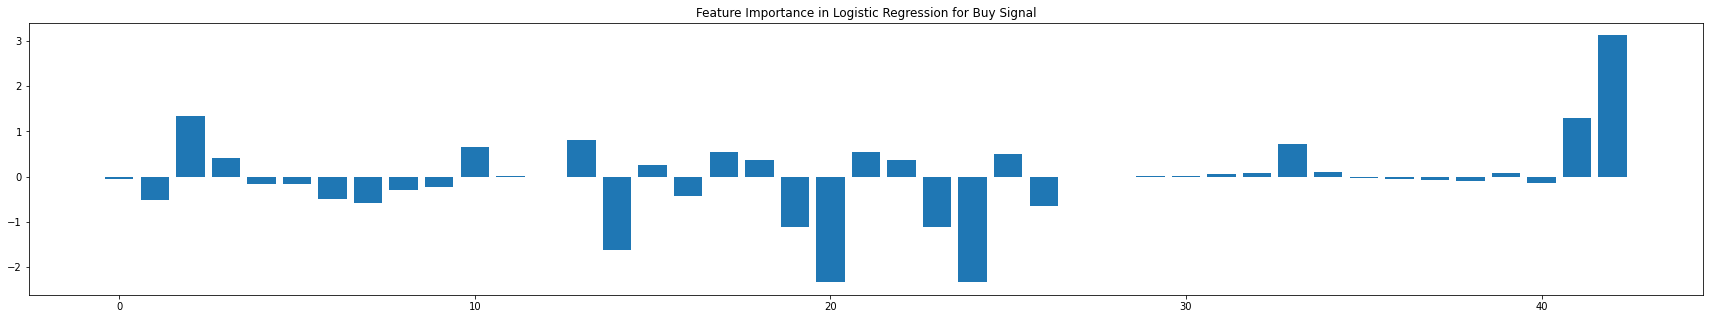

CPU times: user 1.13 s, sys: 292 ms, total: 1.42 s
Wall time: 348 ms


'The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.'

In [394]:
%%time
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# define the model
model = LogisticRegression()
# fit the model
model.fit(features_train.drop(['Date','Symbol','Buy','Sell','TRACKER'],axis=1), features_train.Buy)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(30,5))
pyplot.title('Feature Importance in Logistic Regression for Buy Signal')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
'''The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.'''


Feature: 0, Score: -0.05425
Feature: 1, Score: 0.46693
Feature: 2, Score: -0.60380
Feature: 3, Score: -0.30657
Feature: 4, Score: 0.03020
Feature: 5, Score: 0.03020
Feature: 6, Score: 1.42615
Feature: 7, Score: 0.82151
Feature: 8, Score: 0.50333
Feature: 9, Score: 0.07151
Feature: 10, Score: -0.32742
Feature: 11, Score: -0.02502
Feature: 12, Score: 0.00000
Feature: 13, Score: -0.50357
Feature: 14, Score: -0.46795
Feature: 15, Score: 0.72413
Feature: 16, Score: 1.07810
Feature: 17, Score: -0.35339
Feature: 18, Score: 1.88985
Feature: 19, Score: -0.19812
Feature: 20, Score: 1.69006
Feature: 21, Score: -0.35339
Feature: 22, Score: 1.88985
Feature: 23, Score: -0.19812
Feature: 24, Score: 1.69006
Feature: 25, Score: 0.22983
Feature: 26, Score: 0.27893
Feature: 27, Score: -0.00403
Feature: 28, Score: -0.13091
Feature: 29, Score: -0.09048
Feature: 30, Score: -0.06543
Feature: 31, Score: -0.02481
Feature: 32, Score: 0.01594
Feature: 33, Score: 0.22062
Feature: 34, Score: 0.08212
Feature: 35, S

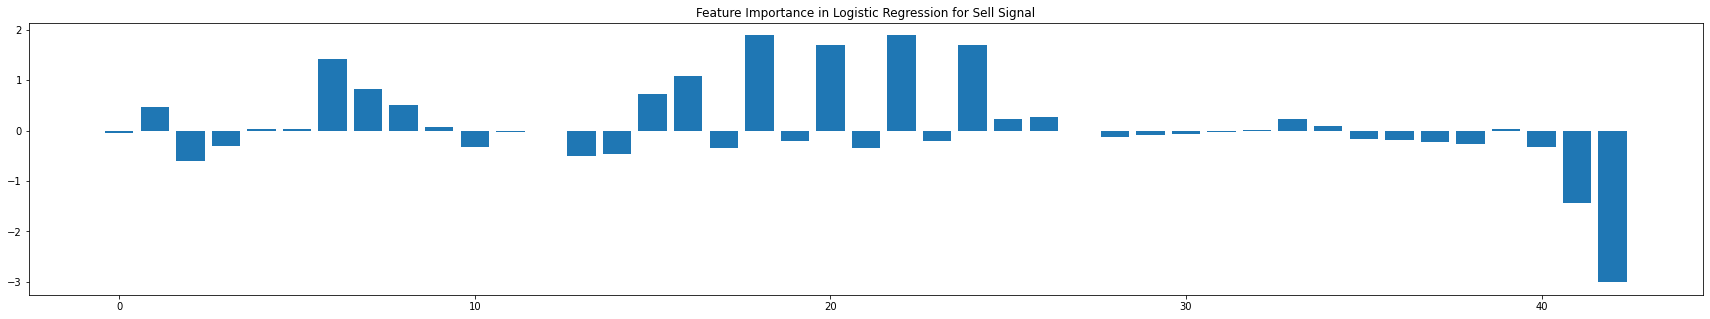

CPU times: user 1.11 s, sys: 306 ms, total: 1.41 s
Wall time: 356 ms


'The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.'

In [395]:
%%time
# define the model
model = LogisticRegression()
# fit the model
model.fit(features_train.drop(['Date','Symbol','Buy','Sell','TRACKER'],axis=1), features_train.Sell)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(30,5))
pyplot.title('Feature Importance in Logistic Regression for Sell Signal')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
'''The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.'''


Feature: 0, Score: 0.01629
Feature: 1, Score: 0.01839
Feature: 2, Score: 0.03415
Feature: 3, Score: 0.01697
Feature: 4, Score: 0.02118
Feature: 5, Score: 0.03297
Feature: 6, Score: 0.04280
Feature: 7, Score: 0.03463
Feature: 8, Score: 0.01647
Feature: 9, Score: 0.01206
Feature: 10, Score: 0.01515
Feature: 11, Score: 0.01222
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.02223
Feature: 14, Score: 0.03216
Feature: 15, Score: 0.01861
Feature: 16, Score: 0.03760
Feature: 17, Score: 0.00319
Feature: 18, Score: 0.00775
Feature: 19, Score: 0.01707
Feature: 20, Score: 0.03257
Feature: 21, Score: 0.01230
Feature: 22, Score: 0.02670
Feature: 23, Score: 0.02965
Feature: 24, Score: 0.08267
Feature: 25, Score: 0.02283
Feature: 26, Score: 0.02140
Feature: 27, Score: 0.01827
Feature: 28, Score: 0.01249
Feature: 29, Score: 0.01319
Feature: 30, Score: 0.00842
Feature: 31, Score: 0.00587
Feature: 32, Score: 0.00800
Feature: 33, Score: 0.00875
Feature: 34, Score: 0.00840
Feature: 35, Score: 0.01804
Fe

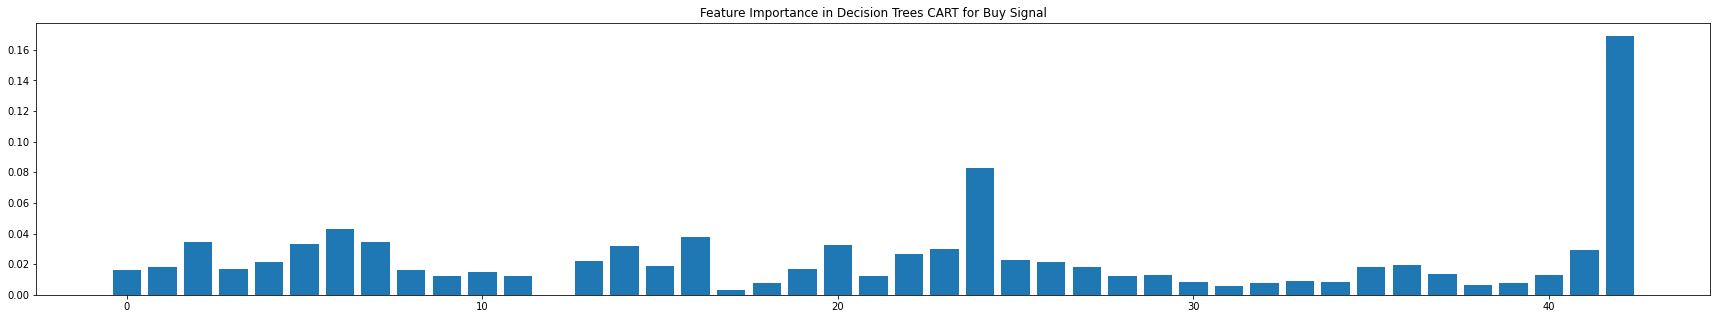

CPU times: user 379 ms, sys: 30 ms, total: 409 ms
Wall time: 403 ms


In [396]:
%%time
from sklearn.tree import DecisionTreeRegressor
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(features_train.drop(['Date','Symbol','Buy','Sell','TRACKER'],axis=1), features_train.Buy)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(30,5))
pyplot.title('Feature Importance in Decision Trees CART for Buy Signal')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.01554
Feature: 1, Score: 0.02922
Feature: 2, Score: 0.03867
Feature: 3, Score: 0.01395
Feature: 4, Score: 0.00729
Feature: 5, Score: 0.02439
Feature: 6, Score: 0.02859
Feature: 7, Score: 0.02260
Feature: 8, Score: 0.01115
Feature: 9, Score: 0.01288
Feature: 10, Score: 0.01661
Feature: 11, Score: 0.01356
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.01873
Feature: 14, Score: 0.03808
Feature: 15, Score: 0.02918
Feature: 16, Score: 0.02980
Feature: 17, Score: 0.00893
Feature: 18, Score: 0.01499
Feature: 19, Score: 0.01158
Feature: 20, Score: 0.02438
Feature: 21, Score: 0.01585
Feature: 22, Score: 0.03472
Feature: 23, Score: 0.00746
Feature: 24, Score: 0.08768
Feature: 25, Score: 0.02093
Feature: 26, Score: 0.02261
Feature: 27, Score: 0.02089
Feature: 28, Score: 0.01341
Feature: 29, Score: 0.01126
Feature: 30, Score: 0.01117
Feature: 31, Score: 0.00494
Feature: 32, Score: 0.00256
Feature: 33, Score: 0.00339
Feature: 34, Score: 0.02250
Feature: 35, Score: 0.02537
Fe

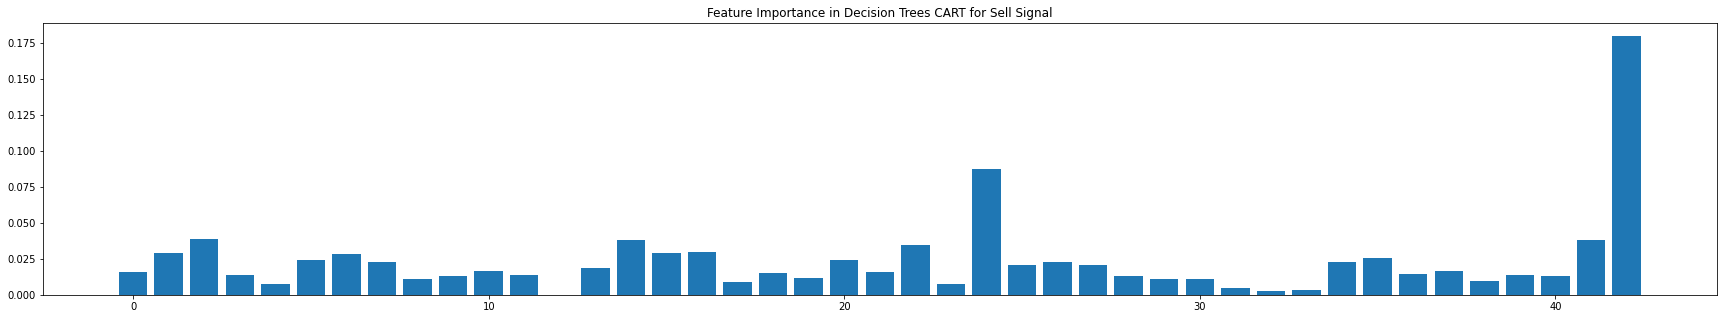

CPU times: user 347 ms, sys: 30.4 ms, total: 377 ms
Wall time: 372 ms


In [397]:
%%time
from sklearn.tree import DecisionTreeRegressor
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(features_train.drop(['Date','Symbol','Buy','Sell','TRACKER'],axis=1), features_train.Sell)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(30,5))
pyplot.title('Feature Importance in Decision Trees CART for Sell Signal')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.03374
Feature: 1, Score: 0.03992
Feature: 2, Score: 0.02655
Feature: 3, Score: 0.02030
Feature: 4, Score: 0.01978
Feature: 5, Score: 0.01824
Feature: 6, Score: 0.03920
Feature: 7, Score: 0.04592
Feature: 8, Score: 0.02911
Feature: 9, Score: 0.03000
Feature: 10, Score: 0.01723
Feature: 11, Score: 0.02133
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.01879
Feature: 14, Score: 0.02272
Feature: 15, Score: 0.02179
Feature: 16, Score: 0.03176
Feature: 17, Score: 0.02079
Feature: 18, Score: 0.01994
Feature: 19, Score: 0.02611
Feature: 20, Score: 0.04199
Feature: 21, Score: 0.02124
Feature: 22, Score: 0.02027
Feature: 23, Score: 0.02563
Feature: 24, Score: 0.04116
Feature: 25, Score: 0.02073
Feature: 26, Score: 0.02664
Feature: 27, Score: 0.02348
Feature: 28, Score: 0.01581
Feature: 29, Score: 0.01720
Feature: 30, Score: 0.01571
Feature: 31, Score: 0.01567
Feature: 32, Score: 0.01606
Feature: 33, Score: 0.01648
Feature: 34, Score: 0.01567
Feature: 35, Score: 0.01547
Fe

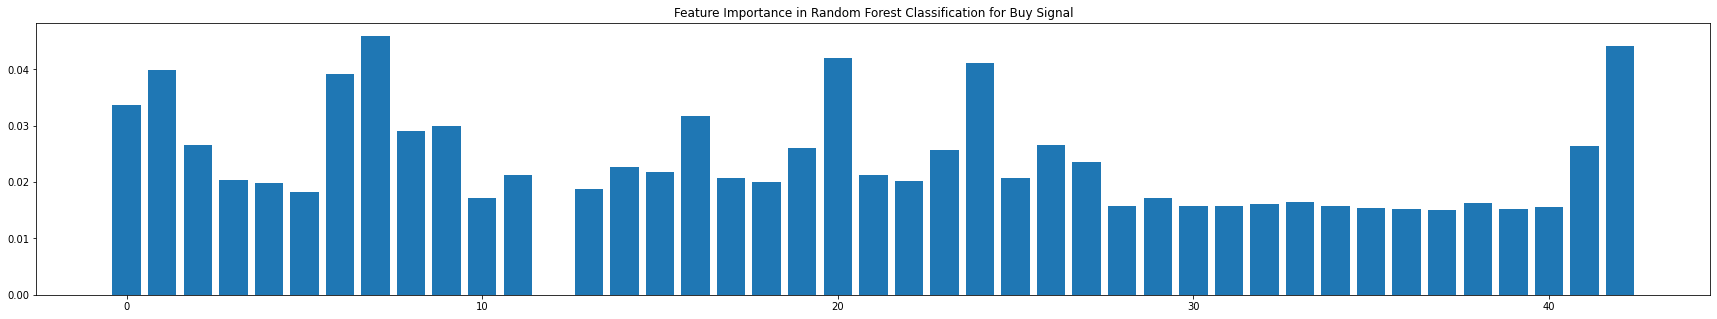

CPU times: user 1.04 s, sys: 26.2 ms, total: 1.07 s
Wall time: 1.06 s


In [398]:
%%time
# random forest for feature importance on a classification problem
from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(features_train.drop(['Date','Symbol','Buy','Sell','TRACKER'],axis=1), features_train.Buy)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(30,5))
pyplot.title('Feature Importance in Random Forest Classification for Buy Signal')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.02764
Feature: 1, Score: 0.06171
Feature: 2, Score: 0.02519
Feature: 3, Score: 0.02113
Feature: 4, Score: 0.02116
Feature: 5, Score: 0.02021
Feature: 6, Score: 0.04449
Feature: 7, Score: 0.04452
Feature: 8, Score: 0.02700
Feature: 9, Score: 0.02882
Feature: 10, Score: 0.02174
Feature: 11, Score: 0.02126
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.01922
Feature: 14, Score: 0.02270
Feature: 15, Score: 0.01988
Feature: 16, Score: 0.03074
Feature: 17, Score: 0.01895
Feature: 18, Score: 0.02557
Feature: 19, Score: 0.02059
Feature: 20, Score: 0.04306
Feature: 21, Score: 0.01809
Feature: 22, Score: 0.03043
Feature: 23, Score: 0.01659
Feature: 24, Score: 0.03895
Feature: 25, Score: 0.01968
Feature: 26, Score: 0.02146
Feature: 27, Score: 0.02302
Feature: 28, Score: 0.01790
Feature: 29, Score: 0.01549
Feature: 30, Score: 0.01569
Feature: 31, Score: 0.01491
Feature: 32, Score: 0.01486
Feature: 33, Score: 0.01427
Feature: 34, Score: 0.01490
Feature: 35, Score: 0.01900
Fe

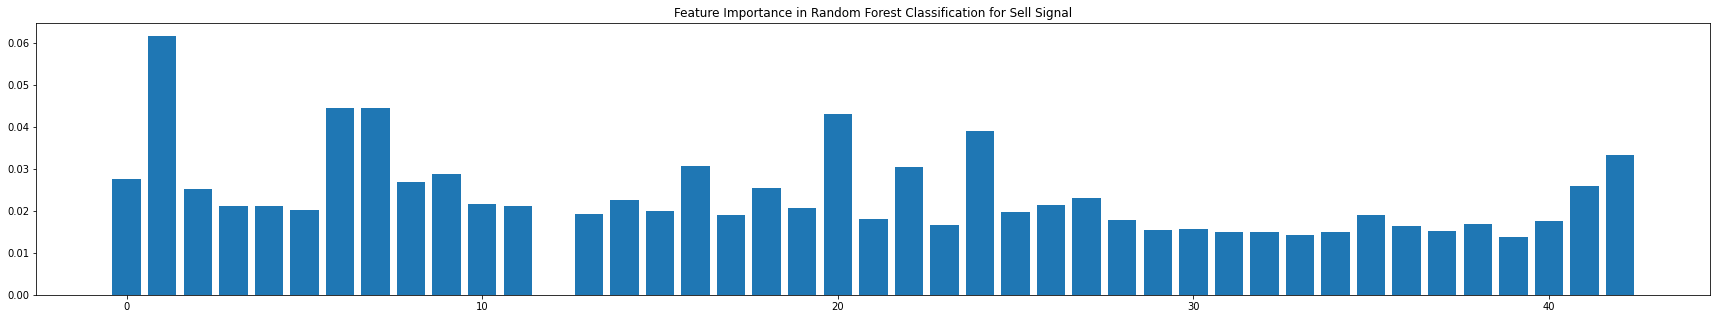

CPU times: user 1.01 s, sys: 23.2 ms, total: 1.04 s
Wall time: 1.03 s


In [399]:
%%time
# random forest for feature importance on a classification problem
from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(features_train.drop(['Date','Symbol','Buy','Sell','TRACKER'],axis=1), features_train.Sell)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(30,5))
pyplot.title('Feature Importance in Random Forest Classification for Sell Signal')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

[12:38:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature: 0, Score: 0.00937
Feature: 1, Score: 0.01185
Feature: 2, Score: 0.01394
Feature: 3, Score: 0.01177
Feature: 4, Score: 0.00826
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00947
Feature: 7, Score: 0.01254
Feature: 8, Score: 0.00994
Feature: 9, Score: 0.01155
Feature: 10, Score: 0.01364
Feature: 11, Score: 0.01142
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00884
Feature: 14, Score: 0.01055
Feature: 15, Score: 0.01139
Feature: 16, Score: 0.01123
Feature: 17, Score: 0.01305
Feature: 18, Score: 0.01228
Feature: 19, Score: 0.01321
Feature: 20, Score: 0.02867
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00911


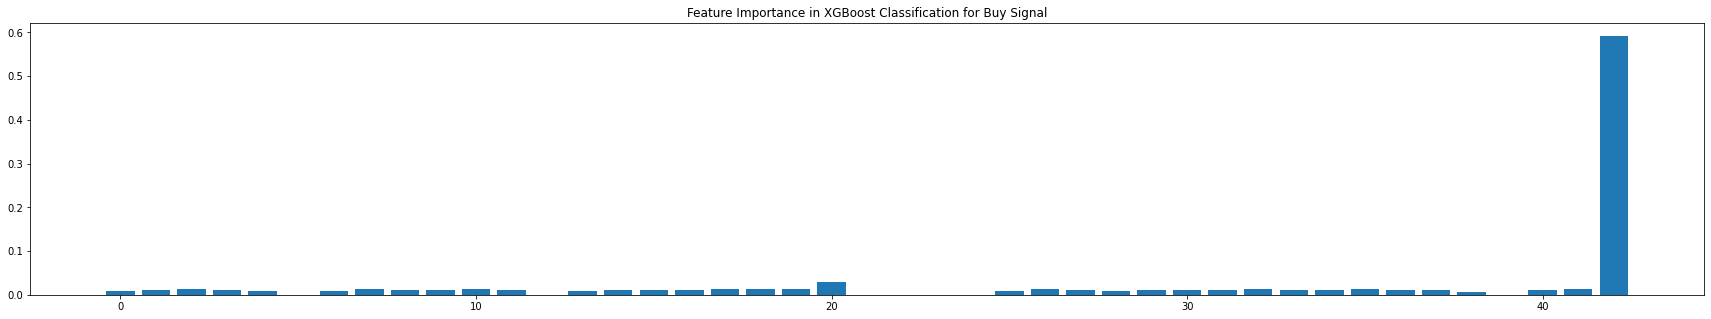

CPU times: user 9.04 s, sys: 240 ms, total: 9.28 s
Wall time: 846 ms


In [400]:
%%time
# xgboost for feature importance on a classification problem
from xgboost import XGBClassifier
# define the model
model = XGBClassifier()
# fit the model
model.fit(features_train.drop(['Date','Symbol','Buy','Sell','TRACKER'],axis=1), features_train.Buy)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(30,5))
pyplot.title('Feature Importance in XGBoost Classification for Buy Signal')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

[12:38:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature: 0, Score: 0.01169
Feature: 1, Score: 0.02284
Feature: 2, Score: 0.01032
Feature: 3, Score: 0.00862
Feature: 4, Score: 0.00830
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.01126
Feature: 7, Score: 0.00898
Feature: 8, Score: 0.00869
Feature: 9, Score: 0.01010
Feature: 10, Score: 0.00769
Feature: 11, Score: 0.00944
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00695
Feature: 14, Score: 0.00883
Feature: 15, Score: 0.00897
Feature: 16, Score: 0.01068
Feature: 17, Score: 0.01018
Feature: 18, Score: 0.01329
Feature: 19, Score: 0.00918
Feature: 20, Score: 0.02469
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00679


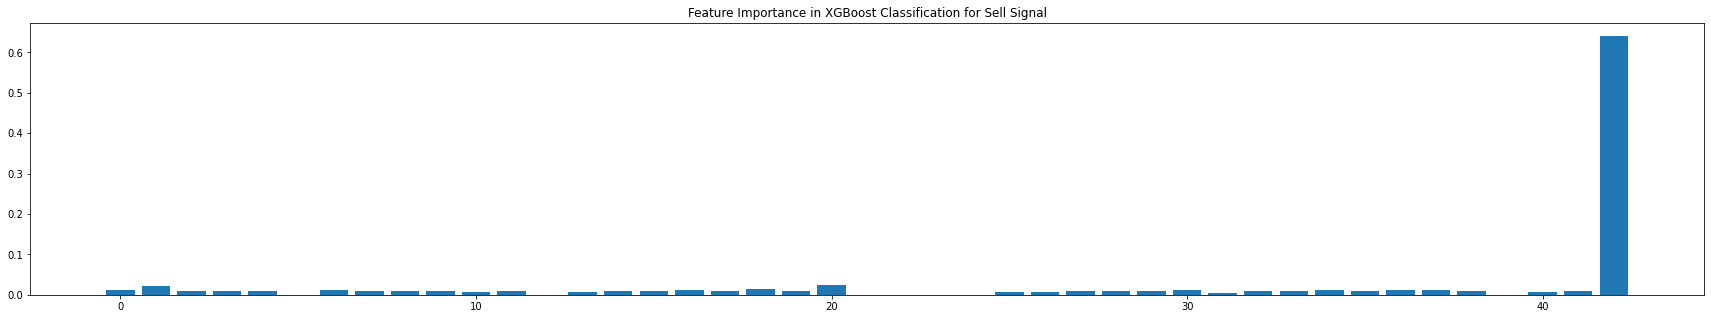

CPU times: user 8.87 s, sys: 207 ms, total: 9.07 s
Wall time: 775 ms


In [401]:
%%time
# xgboost for feature importance on a classification problem
from xgboost import XGBClassifier
# define the model
model = XGBClassifier()
# fit the model
model.fit(features_train.drop(['Date','Symbol','Buy','Sell','TRACKER'],axis=1), features_train.Sell)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.figure(figsize=(30,5))
pyplot.title('Feature Importance in XGBoost Classification for Sell Signal')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [402]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3770 entries, 2010-01-06 09:30:00 to 2015-12-31 17:00:00
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        3770 non-null   object 
 1   Date          3770 non-null   object 
 2   FEMA_21       3770 non-null   float32
 3   FEMA_8        3770 non-null   float32
 4   FADRLo        3770 non-null   float32
 5   FADRHi        3770 non-null   float32
 6   FRVI40        3770 non-null   float32
 7   FRVI60        3770 non-null   float32
 8   FONLOSMA5     3770 non-null   float32
 9   FONHISMA5     3770 non-null   float32
 10  FONLOSMA21    3770 non-null   float32
 11  FONHISMA21    3770 non-null   float32
 12  FONLOSMA34    3770 non-null   float32
 13  FONHISMA34    3770 non-null   float64
 14  FSBGAMMA      3770 non-null   float32
 15  FOPENWEEKLY   3770 non-null   float32
 16  FHIGHWEEKLY   3770 non-null   float32
 17  FLOWWEEKLY    3770 non-null   float

In [403]:
%%time
_C = 1.0
# Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

_kernel = 'poly'
#{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
#Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).

_degree = 3
#int, default=3
#Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

_gamma = 1/42
#{‘scale’, ‘auto’} or float, default=’scale’
#Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

#if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
#if ‘auto’, uses 1 / n_features.
#Changed in version 0.22: The default value of gamma changed from ‘auto’ to ‘scale’.
_coef = 0.1
#0float, default=0.0
#Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.

_shrinking = False
#bool, default=True
#Whether to use the shrinking heuristic. See the User Guide.

_probability = True
#bool, default=False
#Whether to enable probability estimates. This must be enabled prior to calling fit, will slow down that method as it internally uses 5-fold cross-validation, and predict_proba may be inconsistent with predict. Read more in the User Guide.

_tol = 0.003
#float, default=1e-3
#Tolerance for stopping criterion.

_cache_size = 200 
# float, default=200
#Specify the size of the kernel cache (in MB).

_class_weight = 'balanced'
#dict or ‘balanced’, default=None
#Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

_verbose = False
#bool, default=False
#Enable verbose output. Note that this setting takes advantage of a per-process runtime setting in libsvm that, if enabled, may not work properly in a multithreaded context.

_max_iter = -1
#int, default=-1
#Hard limit on iterations within solver, or -1 for no limit.

_decision_function_shape = 'ovr'
#{‘ovo’, ‘ovr’}, default=’ovr’
#Whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2). However, one-vs-one (‘ovo’) is always used as multi-class strategy. The parameter is ignored for binary classification.

#Changed in version 0.19: decision_function_shape is ‘ovr’ by default.
#New in version 0.17: decision_function_shape=’ovr’ is recommended.

#Changed in version 0.17: Deprecated decision_function_shape=’ovo’ and None.
_break_ties = False
#bool, default=False
#If true, decision_function_shape='ovr', and number of classes > 2, predict will break ties according to the confidence values of decision_function; otherwise the first class among the tied classes is returned. Please note that breaking ties comes at a relatively high computational cost compared to a simple predict.

#New in version 0.22.

_random_state = 72
#int or RandomState instance, default=None

_coef0 = 1

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [404]:
%%time

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
import colorama as col
from collections import Counter

_verb = 0

engine.say("Support Vector Machine")
engine.runAndWait()

x = 'EUR/USD'
_model = 'svm'
#_model = 'XGBoostClassifier'
    
print(col.Fore.BLUE,'Support Vector Machine pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)

trainXb = features_train.drop(['Signal','Date','Symbol','Buy','Sell'],axis=1)
testXb = features_test.drop(['Signal','Date','Symbol','Buy','Sell'],axis=1)
trainyb = features_train.Buy
testyb = features_test.Buy

trainXs = features_train.drop(['Signal','Date','Symbol','Buy','Sell'],axis=1)
testXs = features_test.drop(['Signal','Date','Symbol','Buy','Sell'],axis=1)
trainys = features_train.Sell
testys = features_test.Sell


############## B U Y ###################

# summarize class distribution
counterb = Counter(trainyb)

print('Signaux achat',counterb)
#print(counterb[-1],counterb[1])

if counterb[1] > 2 and counterb[0] > 2:

    
    # define model
    modelb = svm.SVC(_C, _kernel,_degree, _gamma, _coef0, _shrinking, _probability, _tol, _cache_size, _class_weight, _verbose, _max_iter, _decision_function_shape, _break_ties, _random_state)
    
    # modelb = svm.SVC() # XGBClassifier() # svm.SVC()
    
    # fit model
    modelb.fit(trainXb, trainyb)
    # predict on test set
    yhatb = modelb.predict(testXb)
    # evaluate predictions
    accub = round(accuracy_score(testyb, yhatb) * 100,2)
    precb = round(precision_score(testyb, yhatb) * 100,2)
    recallb = round(recall_score(testyb, yhatb) * 100,2)
    f1b = round(f1_score(testyb, yhatb) * 100,2)
    
    print(col.Fore.BLUE,'Achat pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    if accub > 69 and precb > 69 :
        print(col.Fore.GREEN)
    elif accub < 51 or precb < 51 :
        print(col.Fore.RED)
    else:
        print(col.Fore.YELLOW)

    print('Achat - Accuracy :' ,accub,'%')
    print('Achat - Precision :',precb,'%')
    print('Achat - Recall :', recallb,'%')
    print('Achat - F-measure: :' ,f1b,'%',col.Style.RESET_ALL)
    print('\n')

    
    print(classification_report(testyb, yhatb))
    conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
    conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
    conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
    print(conf_matrix)
    print(confusion_matrix(testyb, yhatb))
    print('\n')

    savenameb = 'JOBLIB/'+_model+'/Save'+x.replace('/','')+'_buy.sav'

    # serialize model to JOBLIB
    joblib.dump(modelb, savenameb)
    print(col.Fore.BLUE,"Joblib Model ",savenameb," dumped to disk",col.Style.RESET_ALL)
    
    precisionb, recallb, thresholdsb = precision_recall_curve(testyb, yhatb)
    # plot the roc curve for the model
    no_skillb= len(testyb[testyb==1]) / len(testyb)

    # convert to f score
    fscoreb = (2 * precisionb * recallb) / (precisionb + recallb)
    # locate the index of the largest f score
    ixb = argmax(fscoreb)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholdsb[ixb], fscoreb[ixb]))
    

    if _verb == 1:
        plt.ion()
        plt.figure(figsize=(12,4))
        plt.suptitle('Recall_Precision Curve la dataframe')
        plt.plot([0,1], [no_skillb,no_skillb], linestyle='--', label='No Skill')
        plt.plot(recallb, precisionb, marker='.', label='Logistic')
        plt.scatter(recallb[ixb], precisionb[ixb], marker='o', color='black', label='Best')
        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        # show the plot
        plt.show()

else:
    print(col.Fore.RED,'Not enough populated for',col.Fore.YELLOW,x,col.Style.RESET_ALL)


############ S E L L ###############

# summarize class distribution
counters = Counter(trainys)

print('Signaux achat',counters)
#print(counterb[-1],counterb[1])

if counters[1] > 2 and counters[0] > 2:

    
    # define model
    models = svm.SVC(_C, _kernel,_degree, _gamma, _coef0, _shrinking, _probability, _tol, _cache_size, _class_weight, _verbose, _max_iter, _decision_function_shape, _break_ties, _random_state)
    
    
    #models = svm.SVC() # XGBClassifier() # svm.SVC()
    
    
    # fit model
    models.fit(trainXs, trainys)
    # predict on test set
    yhats = models.predict(testXs)
    # evaluate predictions
    accus = round(accuracy_score(testys, yhats) * 100,2)
    precs = round(precision_score(testys, yhats) * 100,2)
    recalls = round(recall_score(testys, yhats) * 100,2)
    f1s = round(f1_score(testys, yhats) * 100,2)
    
    print(col.Fore.BLUE,'Vente pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    if accus > 69 and precs > 69 :
        print(col.Fore.GREEN)
    elif accus < 51 or precs < 51 :
        print(col.Fore.RED)
    else:
        print(col.Fore.YELLOW)

    print('Vente - Accuracy :' ,accus,'%')
    print('Vente - Precision :',precs,'%')
    print('Vente - Recall :', recalls,'%')
    print('Vente - F-measure: :' ,f1s,'%',col.Style.RESET_ALL)
    print('\n')

    
    print(classification_report(testys, yhats))
    print(conf_matrix)
    print(confusion_matrix(testys, yhats))
    print('\n')

    savenames = 'JOBLIB/'+_model+'/Save'+x.replace('/','')+'_sell.sav'
    
    # serialize model to JOBLIB
    joblib.dump(models, savenames)
    print(col.Fore.BLUE,"Joblib Model ",savenames," dumped to disk",col.Style.RESET_ALL)
    
    precisions, recalls, thresholdss = precision_recall_curve(testys, yhats)
    # plot the roc curve for the model
    no_skills= len(testys[testys==1]) / len(testys)

    # convert to f score
    fscores = (2 * precisions * recalls) / (precisions + recalls)
    # locate the index of the largest f score
    ixs = argmax(fscores)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholdsb[ixs], fscoreb[ixs]))
    

    if _verb == 1:
        plt.ion()
        plt.figure(figsize=(12,4))
        plt.suptitle('Recall_Precision Curve la dataframe pour les signaux de vente')
        plt.plot([0,1], [no_skills,no_skills], linestyle='--', label='No Skill')
        plt.plot(recalls, precisions, marker='.', label='Logistic')
        plt.scatter(recallb[ixs], precisionb[ixs], marker='o', color='black', label='Best')
        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        # show the plot
        plt.show()

else:
    print(col.Fore.RED,'Not enough populated for',col.Fore.YELLOW,x,col.Style.RESET_ALL)


 Support Vector Machine pour  EUR/USD 
Signaux achat Counter({0: 3193, 1: 577})
 Achat pour  EUR/USD 

Achat - Accuracy : 96.39 %
Achat - Precision : 95.57 %
Achat - Recall : 74.33 %
Achat - F-measure: : 83.62 % 


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1843
           1       0.96      0.74      0.84       261

    accuracy                           0.96      2104
   macro avg       0.96      0.87      0.91      2104
weighted avg       0.96      0.96      0.96      2104

              Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs
[[1834    9]
 [  67  194]]


 Joblib Model  JOBLIB/svm/SaveEURUSD_buy.sav  dumped to disk 
Best Threshold=1.000000, F-Score=0.836
Signaux achat Counter({0: 3227, 1: 543})
 Vente pour  EUR/USD 

Vente - Accuracy : 94.77 %
Vente - Precision : 70.97 %
Vente - Recall : 95.65 %
Vente - F-measure: : 81.48 % 


              precis

In [405]:
features_oos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1566 entries, 2019-01-02 14:15:00 to 2020-12-31 16:45:00
Data columns (total 46 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        1566 non-null   object 
 1   Date          1566 non-null   object 
 2   FEMA_21       1566 non-null   float64
 3   FEMA_8        1566 non-null   float64
 4   FADRLo        1566 non-null   float64
 5   FADRHi        1566 non-null   float64
 6   FRVI40        1566 non-null   float64
 7   FRVI60        1566 non-null   float64
 8   FONLOSMA5     1566 non-null   float64
 9   FONHISMA5     1566 non-null   float64
 10  FONLOSMA21    1566 non-null   float64
 11  FONHISMA21    1566 non-null   float64
 12  FONLOSMA34    1566 non-null   float64
 13  FONHISMA34    1566 non-null   float64
 14  FSBGAMMA      1566 non-null   float64
 15  FOPENWEEKLY   1566 non-null   float64
 16  FHIGHWEEKLY   1566 non-null   float64
 17  FLOWWEEKLY    1566 non-null   float

In [406]:
%%time
_ticker='EURUSD'
df_all = joblib.load('JOBLIB/df_all')
df_all_oos = df_all.copy()
df_all_oos = df_all_oos[df_all_oos.Symbol==_ticker]
df_all_oos = df_all_oos[df_all_oos.Date>'2018-12-31']

CPU times: user 5.86 s, sys: 5.41 s, total: 11.3 s
Wall time: 11.5 s


In [407]:
%%time
print('Signaux Achat Potentiels',len(df_all_oos[df_all_oos.Signal==1]))
print('Signaux Vente Potentiels',len(df_all_oos[df_all_oos.Signal==-1]))

Signaux Achat Potentiels 707
Signaux Vente Potentiels 860
CPU times: user 3.95 ms, sys: 2.23 ms, total: 6.19 ms
Wall time: 4.13 ms


In [408]:
%%time
features_oos['Symbol'] = df_all_oos['Symbol']
features_oos['Date'] = df_all_oos['Date']
features_oos['FEMA_21'] = df_all_oos['Close'] - df_all_oos['EMA_21']
features_oos['FEMA_8'] = df_all_oos['Close'] - df_all_oos['EMA_8']
features_oos['FADRLo'] = df_all_oos['Close'] - df_all_oos['ADR_Low']
features_oos['FADRHi'] = df_all_oos['Close'] - df_all_oos['ADR_High']
features_oos['FRVI40'] = df_all_oos['RVI'] - 40
features_oos['FRVI60'] = df_all_oos['RVI'] - 60
features_oos['FONLOSMA5'] = df_all_oos['Low'] - df_all_oos['ONLOSMA_5']
features_oos['FONHISMA5'] = df_all_oos['High'] - df_all_oos['ONHISMA_5']
features_oos['FONLOSMA21'] = df_all_oos['Low'] - df_all_oos['ONLOSMA_21']
features_oos['FONHISMA21'] = df_all_oos['High'] - df_all_oos['ONHISMA_21']
features_oos['FONLOSMA34'] = df_all_oos['Low'] - df_all_oos['ONLOSMA_34']
features_oos['FONHISMA34'] = df_all_oos['High'] - df_all_oos['ONHISMA_34']
features_oos['FSBGAMMA'] = df_all_oos['SB_Gamma']
features_oos['FOPENWEEKLY'] = df_all_oos['Close'] - df_all_oos['Open_weekly']
features_oos['FHIGHWEEKLY'] = df_all_oos['Close'] - df_all_oos['High_weekly']
features_oos['FLOWWEEKLY'] = df_all_oos['Close'] - df_all_oos['Low_weekly']
features_oos['FCLOSEWEEKLY'] = df_all_oos['Close'] - df_all_oos['Close_weekly']
features_oos['FOPENDAILY'] = df_all_oos['Close'] - df_all_oos['Open_daily']
features_oos['FHIGHDAILY'] = df_all_oos['Close'] - df_all_oos['High_daily']
features_oos['FLOWDAILY'] = df_all_oos['Close'] - df_all_oos['Low_daily']
features_oos['FCLOSEDAILY'] = df_all_oos['Close'] - df_all_oos['Close_daily']
features_oos['FOPENHOURLY'] = df_all_oos['Close'] - df_all_oos['Open_daily']
features_oos['FHIGHHOURLY'] = df_all_oos['Close'] - df_all_oos['High_daily']
features_oos['FLOWHOURLY'] = df_all_oos['Close'] - df_all_oos['Low_daily']
features_oos['FCLOSEHOURLY'] = df_all_oos['Close'] - df_all_oos['Close_daily']
features_oos['FSMA200'] = df_all_oos['Close'] - df_all_oos['SMA_200']
features_oos['FBOLUP20'] = df_all_oos['Close'] - df_all_oos['UpperBand']
features_oos['FBOLLOW20'] = df_all_oos['Close'] - df_all_oos['LowerBand']
features_oos['FPP'] = df_all_oos['Close'] - df_all_oos['PP']
features_oos['FS38'] = df_all_oos['Close'] - df_all_oos['S38']
features_oos['FS62'] = df_all_oos['Close'] - df_all_oos['S62']
features_oos['FS100'] = df_all_oos['Close'] - df_all_oos['S100']
features_oos['FS138'] = df_all_oos['Close'] - df_all_oos['S138']
features_oos['FS162'] = df_all_oos['Close'] - df_all_oos['S162']
features_oos['FS200'] = df_all_oos['Close'] - df_all_oos['S200']
features_oos['FR38'] = df_all_oos['Close'] - df_all_oos['R38']
features_oos['FR62'] = df_all_oos['Close'] - df_all_oos['R62']
features_oos['FR100'] = df_all_oos['Close'] - df_all_oos['R100']
features_oos['FR138'] = df_all_oos['Close'] - df_all_oos['R138']
features_oos['FR162'] = df_all_oos['Close'] - df_all_oos['R162']
features_oos['FR200'] = df_all_oos['Close'] - df_all_oos['R200']
features_oos['SBATR'] = (df_all_oos['Close'] - df_all_oos['Open']) / df_all_oos['ATR_14']
features_oos['Signal'] = df_all_oos['Signal']

features_oos['FEMA_21'] = scaler.fit_transform(np.nan_to_num(features_oos.FEMA_21.astype(np.float32)).reshape(-1, 1))
features_oos['FEMA_8'] = scaler.fit_transform(np.nan_to_num(features_oos.FEMA_8.astype(np.float32)).reshape(-1, 1))
features_oos['FADRLo'] = scaler.fit_transform(np.nan_to_num(features_oos.FADRLo.astype(np.float32)).reshape(-1, 1))
features_oos['FADRHi'] = scaler.fit_transform(np.nan_to_num(features_oos.FADRHi.astype(np.float32)).reshape(-1, 1))
features_oos['FRVI40'] = scaler.fit_transform(np.nan_to_num(features_oos.FRVI40.astype(np.float32)).reshape(-1, 1))
features_oos['FRVI60'] = scaler.fit_transform(np.nan_to_num(features_oos.FRVI60.astype(np.float32)).reshape(-1, 1))
features_oos['FONLOSMA5'] = scaler.fit_transform(np.nan_to_num(features_oos.FONLOSMA5.astype(np.float32)).reshape(-1, 1))
features_oos['FONHISMA5'] = scaler.fit_transform(np.nan_to_num(features_oos.FONHISMA5.astype(np.float32)).reshape(-1, 1))
features_oos['FONLOSMA21'] = scaler.fit_transform(np.nan_to_num(features_oos.FONLOSMA21.astype(np.float32)).reshape(-1, 1))
features_oos['FONHISMA21'] = scaler.fit_transform(np.nan_to_num(features_oos.FONHISMA21.astype(np.float32)).reshape(-1, 1))
features_oos['FONLOSMA34'] = scaler.fit_transform(np.nan_to_num(features_oos.FONLOSMA34.astype(np.float32)).reshape(-1, 1))
features_oos['FSBGAMMA'] = scaler.fit_transform(np.nan_to_num(features_oos.FSBGAMMA.astype(np.float32)).reshape(-1, 1))
features_oos['FOPENWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_oos.FOPENWEEKLY.astype(np.float32)).reshape(-1, 1))
features_oos['FHIGHWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_oos.FHIGHWEEKLY.astype(np.float32)).reshape(-1, 1))
features_oos['FLOWWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_oos.FLOWWEEKLY.astype(np.float32)).reshape(-1, 1))
features_oos['FCLOSEWEEKLY'] = scaler.fit_transform(np.nan_to_num(features_oos.FCLOSEWEEKLY.astype(np.float32)).reshape(-1, 1))
features_oos['FOPENDAILY'] = scaler.fit_transform(np.nan_to_num(features_oos.FOPENDAILY.astype(np.float32)).reshape(-1, 1))
features_oos['FHIGHDAILY'] = scaler.fit_transform(np.nan_to_num(features_oos.FHIGHDAILY.astype(np.float32)).reshape(-1, 1))
features_oos['FLOWDAILY'] = scaler.fit_transform(np.nan_to_num(features_oos.FLOWDAILY.astype(np.float32)).reshape(-1, 1))
features_oos['FCLOSEDAILY'] = scaler.fit_transform(np.nan_to_num(features_oos.FCLOSEDAILY.astype(np.float32)).reshape(-1, 1))
features_oos['FOPENHOURLY'] = scaler.fit_transform(np.nan_to_num(features_oos.FOPENHOURLY.astype(np.float32)).reshape(-1, 1))
features_oos['FHIGHHOURLY'] = scaler.fit_transform(np.nan_to_num(features_oos.FHIGHHOURLY.astype(np.float32)).reshape(-1, 1))
features_oos['FLOWHOURLY'] = scaler.fit_transform(np.nan_to_num(features_oos.FLOWHOURLY.astype(np.float32)).reshape(-1, 1))
features_oos['FCLOSEHOURLY'] = scaler.fit_transform(np.nan_to_num(features_oos.FCLOSEHOURLY.astype(np.float32)).reshape(-1, 1))
features_oos['FSMA200'] = scaler.fit_transform(np.nan_to_num(features_oos.FSMA200.astype(np.float32)).reshape(-1, 1))
features_oos['FBOLUP20'] = scaler.fit_transform(np.nan_to_num(features_oos.FBOLUP20.astype(np.float32)).reshape(-1, 1))
features_oos['FPP'] = scaler.fit_transform(np.nan_to_num(features_oos.FPP.astype(np.float32)).reshape(-1, 1))
features_oos['FS38'] = scaler.fit_transform(np.nan_to_num(features_oos.FS38.astype(np.float32)).reshape(-1, 1))
features_oos['FS62'] = scaler.fit_transform(np.nan_to_num(features_oos.FS62.astype(np.float32)).reshape(-1, 1))
features_oos['FS100'] = scaler.fit_transform(np.nan_to_num(features_oos.FS100.astype(np.float32)).reshape(-1, 1))
features_oos['FS138'] = scaler.fit_transform(np.nan_to_num(features_oos.FS138.astype(np.float32)).reshape(-1, 1))
features_oos['FR162'] = scaler.fit_transform(np.nan_to_num(features_oos.FS162.astype(np.float32)).reshape(-1, 1))
features_oos['FS200'] = scaler.fit_transform(np.nan_to_num(features_oos.FS200.astype(np.float32)).reshape(-1, 1))
features_oos['FR38'] = scaler.fit_transform(np.nan_to_num(features_oos.FR38.astype(np.float32)).reshape(-1, 1))
features_oos['FR62'] = scaler.fit_transform(np.nan_to_num(features_oos.FR62.astype(np.float32)).reshape(-1, 1))
features_oos['FR100'] = scaler.fit_transform(np.nan_to_num(features_oos.FR100.astype(np.float32)).reshape(-1, 1))
features_oos['FR138'] = scaler.fit_transform(np.nan_to_num(features_oos.FR138.astype(np.float32)).reshape(-1, 1))
features_oos['FR162'] = scaler.fit_transform(np.nan_to_num(features_oos.FR162.astype(np.float32)).reshape(-1, 1))
features_oos['FR200'] = scaler.fit_transform(np.nan_to_num(features_oos.FR200.astype(np.float32)).reshape(-1, 1))
features_oos['SBATR'] = scaler.fit_transform(np.nan_to_num(features_oos.SBATR.astype(np.float32)).reshape(-1, 1))

CPU times: user 63.2 ms, sys: 8.44 ms, total: 71.7 ms
Wall time: 59.2 ms


In [409]:
%%time
features_oos['Buy'] = 0
features_oos['Sell'] = 0
features_oos['Buy'] = np.where(features_oos.Signal==1,modelb.predict(features_oos.drop(['Date','Symbol','TRACKER','Buy','Sell'],axis=1)),0)
features_oos['Sell'] = np.where(features_oos.Signal==-1,models.predict(features_oos.drop(['Date','Symbol','TRACKER','Buy','Sell'],axis=1)),0)

CPU times: user 80.7 ms, sys: 1.78 ms, total: 82.4 ms
Wall time: 81.2 ms


In [410]:
%%time
print('Signaux Achat',len(features_oos[features_oos.Buy!=0]))
print('Signaux Vente',len(features_oos[features_oos.Sell!=0]))

Signaux Achat 403
Signaux Vente 0
CPU times: user 1.8 ms, sys: 747 µs, total: 2.55 ms
Wall time: 1.84 ms


In [411]:
%%time
df_all_oos = df_all_oos.drop(['Signal'],axis=1)
df_all_oos['Signal'] = np.where(df_all_oos.index.isin(features_oos[features_oos.Buy==1].index),1,np.where(df_all_oos.index.isin(features_oos[features_oos.Sell==0].index),-1,0))

CPU times: user 10.2 ms, sys: 1.14 ms, total: 11.3 ms
Wall time: 9.8 ms


In [412]:
print('Signaux Achat',len(df_all_oos[df_all_oos.Signal==1]))
print('Signaux Vente',len(df_all_oos[df_all_oos.Signal==-1]))

Signaux Achat 403
Signaux Vente 1163


In [413]:
##### On backtest selon le ticker selectionné sur la période déterminée

x='EUR/USD'
_year_bottom = '2019-01-01'
_year_top = '2020-12-31'
_nb_bougie_exit = 96
_trigger_reengage = 0
_trigger_target = 0
_trigger_invers = 1
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
_target = 0.002
_exposure = 10
_size = 50000
_sl = 0.002
_open_hour = 8 # day only
_close_hour = 23 # day only
_window = 0 # day only

In [414]:
%%time
##### Backtest Over Night
TRACKER = bt(df_all_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2021-01-26 12:39:12.523638

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 48057/48057 [00:02<00:00, 17964.25it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  11457.5 !. En  496   transactions.
 
Nbre de winners : 297 
 
Nbre de loosers : 199 
Temps d'excution du BT 0:00:08.990376
 EUR/USD  results 
 Tested Period 2019-01-01  à 2020-12-31 
 Total Number of trades 496 
Started Cash : 50000
P&L  in currency:  11457.5$ 
P&L in %:  5.73% 
Average trade duration 63.28
# Winners  297.0
# Loosers  199.0
Cumulated gains 39366.5
Cumulated losses -27909.0
 PROFIT FACTOR :  1.41 
 Winners Ratio : 59.88 % 
Average Winners 132.55
% Average Winners 0.07
Average Loosers -140.25
% Average Loosers -0.07
Average pnl 23.1
% Average pnl 0.01
Number of opened trades 496
Number of closed trades 496
Max Exposure 1 x  50000 =  50000 $

In [423]:
%%time
minute = pd.read_csv('../BASES/Base/EURUSD_m1_BidAndAsk.csv')
minute.set_index(pd.to_datetime(minute['Date']+' '+minute['Time']),drop=True,inplace=True)

CPU times: user 1min 45s, sys: 461 ms, total: 1min 45s
Wall time: 1min 45s


In [427]:
%%time
TICKER_LIST = ['EUR/USD']
_period='m1'
minute = get_all_data(TICKER_LIST,_period=_period)
minute = timerange1D(minute)
minute = getadr(daily_all,minute,TICKER_LIST)
minute = adrhnl(daily_all,minute,TICKER_LIST)
minute = sma(df_all=minute,_window=200)
minute = bollinger(minute,_slow=20)
minute = slowstochastic(minute,TICKER_LIST)
minute = ema(minute,21,TICKER_LIST)
minute = ema(minute,8,TICKER_LIST)
minute = pivotimportdf(minute,weekly_all,TICKER_LIST)
minute = atr(minute,TICKER_LIST,14)
minute = rvi(minute,TICKER_LIST,_window=14)
minute = sbgamma(minute,TICKER_LIST)
minute = onhisma(minute,TICKER_LIST,_window=5)
minute = onlosma(minute,TICKER_LIST,_window=5)
minute = onhisma(minute,TICKER_LIST,_window=21)
minute = onlosma(minute,TICKER_LIST,_window=21)
minute = onhisma(minute,TICKER_LIST,_window=34)
minute = onlosma(minute,TICKER_LIST,_window=34)
minute = importohlc(minute,weekly_all,TICKER_LIST,_suffix='_weekly')
minute = importohlc(df_all=minute,other_all=daily_all,TICKER_LIST=TICKER_LIST,_suffix='_daily')


100%|██████████| 1/1 [00:00<00:00, 5133.79it/s]
Récupération des data intraday


Ajout Date
100%|██████████| 1/1 [00:00<00:00, 4128.25it/s]
Récupération de l'ADR en cours...


Calcul du ADR High & Low
En cours...
100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]

Calcul SMA

Calcul BOLLINGER
100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]
Calcul du Slow STOCHASTIC
Fenêtre de Glissement : 5 periodes.
Période de lissage : 3 periodes.

100%|██████████| 1/1 [00:00<00:00, 14074.85it/s]
Calcul de l'EMA_21en cours

100%|██████████| 1/1 [00:00<00:00, 6710.89it/s]
Processus de calcul de l'EMA_21terminé

Calcul de l'EMA_8en cours


Processus de calcul de l'EMA_8terminé
100%|██████████| 1/1 [00:00<00:00, 13357.66it/s]
Calcul ATR

100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]
Calcul du RVI

100%|██████████| 1/1 [00:00<00:00, 6955.73it/s]
Calcul ONHISMA
On High Simple Moving Average Calculation

100%|██████████| 1/1 [00:00<00:00, 4346.43it/s]
Calcul ONLOSMA
On High Simple Moving Average Calculati

In [428]:
joblib.dump(minute,'JOBLIB/minute')

['JOBLIB/minute']

In [431]:
%%time
_condition_7 = (minute.slow_K5 < 20) & (minute.slow_K5.shift(1) < minute.slow_D5.shift(1)) & (minute.slow_K5 > minute.slow_D5)

_condition_7_bar = (minute.slow_K5 > 80) & (minute.slow_K5.shift(1) > minute.slow_D5.shift(1)) & (minute.slow_K5 < minute.slow_D5)

##### 1 condition
minute['Signal'] = np.where(_condition_7,1,np.where(_condition_7_bar,-1,0))


CPU times: user 87.1 ms, sys: 7.55 ms, total: 94.7 ms
Wall time: 53.3 ms


In [433]:
%%time
_minute = pd.DataFrame()
_minute['Symbol'] = minute['Symbol']
_minute['Date'] = minute['Date']
_minute['FEMA_21'] = minute['Close'] - minute['EMA_21']
_minute['FEMA_8'] = minute['Close'] - minute['EMA_8']
_minute['FADRLo'] = minute['Close'] - minute['ADR_Low']
_minute['FADRHi'] = minute['Close'] - minute['ADR_High']
_minute['FRVI40'] = minute['RVI'] - 40
_minute['FRVI60'] = minute['RVI'] - 60
_minute['FONLOSMA5'] = minute['Low'] - minute['ONLOSMA_5']
_minute['FONHISMA5'] = minute['High'] - minute['ONHISMA_5']
_minute['FONLOSMA21'] = minute['Low'] - minute['ONLOSMA_21']
_minute['FONHISMA21'] = minute['High'] - minute['ONHISMA_21']
_minute['FONLOSMA34'] = minute['Low'] - minute['ONLOSMA_34']
_minute['FONHISMA34'] = minute['High'] - minute['ONHISMA_34']
_minute['FSBGAMMA'] = minute['SB_Gamma']
_minute['FOPENWEEKLY'] = minute['Close'] - minute['Open_weekly']
_minute['FHIGHWEEKLY'] = minute['Close'] - minute['High_weekly']
_minute['FLOWWEEKLY'] = minute['Close'] - minute['Low_weekly']
_minute['FCLOSEWEEKLY'] = minute['Close'] - minute['Close_weekly']
_minute['FOPENDAILY'] = minute['Close'] - minute['Open_daily']
_minute['FHIGHDAILY'] = minute['Close'] - minute['High_daily']
_minute['FLOWDAILY'] = minute['Close'] - minute['Low_daily']
_minute['FCLOSEDAILY'] = minute['Close'] - minute['Close_daily']
_minute['FOPENHOURLY'] = minute['Close'] - minute['Open_daily']
_minute['FHIGHHOURLY'] = minute['Close'] - minute['High_daily']
_minute['FLOWHOURLY'] = minute['Close'] - minute['Low_daily']
_minute['FCLOSEHOURLY'] = minute['Close'] - minute['Close_daily']
_minute['FSMA200'] = minute['Close'] - minute['SMA_200']
_minute['FBOLUP20'] = minute['Close'] - minute['UpperBand']
_minute['FBOLLOW20'] = minute['Close'] - minute['LowerBand']
_minute['FPP'] = minute['Close'] - minute['PP']
_minute['FS38'] = minute['Close'] - minute['S38']
_minute['FS62'] = minute['Close'] - minute['S62']
_minute['FS100'] = minute['Close'] - minute['S100']
_minute['FS138'] = minute['Close'] - minute['S138']
_minute['FS162'] = minute['Close'] - minute['S162']
_minute['FS200'] = minute['Close'] - minute['S200']
_minute['FR38'] = minute['Close'] - minute['R38']
_minute['FR62'] = minute['Close'] - minute['R62']
_minute['FR100'] = minute['Close'] - minute['R100']
_minute['FR138'] = minute['Close'] - minute['R138']
_minute['FR162'] = minute['Close'] - minute['R162']
_minute['FR200'] = minute['Close'] - minute['R200']
_minute['SBATR'] = (minute['Close'] - minute['Open']) / minute['ATR_14']
_minute['Signal'] = minute['Signal']


CPU times: user 5.2 s, sys: 416 ms, total: 5.62 s
Wall time: 5.17 s


In [435]:
%%time
_minute = _minute.dropna()

In [436]:
%%time
_minute['FEMA_21'] = scaler.fit_transform(np.nan_to_num(_minute.FEMA_21.astype(np.float32)).reshape(-1, 1))
_minute['FEMA_8'] = scaler.fit_transform(np.nan_to_num(_minute.FEMA_8.astype(np.float32)).reshape(-1, 1))
_minute['FADRLo'] = scaler.fit_transform(np.nan_to_num(_minute.FADRLo.astype(np.float32)).reshape(-1, 1))
_minute['FADRHi'] = scaler.fit_transform(np.nan_to_num(_minute.FADRHi.astype(np.float32)).reshape(-1, 1))
_minute['FRVI40'] = scaler.fit_transform(np.nan_to_num(_minute.FRVI40.astype(np.float32)).reshape(-1, 1))
_minute['FRVI60'] = scaler.fit_transform(np.nan_to_num(_minute.FRVI60.astype(np.float32)).reshape(-1, 1))
_minute['FONLOSMA5'] = scaler.fit_transform(np.nan_to_num(_minute.FONLOSMA5.astype(np.float32)).reshape(-1, 1))
_minute['FONHISMA5'] = scaler.fit_transform(np.nan_to_num(_minute.FONHISMA5.astype(np.float32)).reshape(-1, 1))
_minute['FONLOSMA21'] = scaler.fit_transform(np.nan_to_num(_minute.FONLOSMA21.astype(np.float32)).reshape(-1, 1))
_minute['FONHISMA21'] = scaler.fit_transform(np.nan_to_num(_minute.FONHISMA21.astype(np.float32)).reshape(-1, 1))
_minute['FONLOSMA34'] = scaler.fit_transform(np.nan_to_num(_minute.FONLOSMA34.astype(np.float32)).reshape(-1, 1))
_minute['FSBGAMMA'] = scaler.fit_transform(np.nan_to_num(_minute.FSBGAMMA.astype(np.float32)).reshape(-1, 1))
_minute['FOPENWEEKLY'] = scaler.fit_transform(np.nan_to_num(_minute.FOPENWEEKLY.astype(np.float32)).reshape(-1, 1))
_minute['FHIGHWEEKLY'] = scaler.fit_transform(np.nan_to_num(_minute.FHIGHWEEKLY.astype(np.float32)).reshape(-1, 1))
_minute['FLOWWEEKLY'] = scaler.fit_transform(np.nan_to_num(_minute.FLOWWEEKLY.astype(np.float32)).reshape(-1, 1))
_minute['FCLOSEWEEKLY'] = scaler.fit_transform(np.nan_to_num(_minute.FCLOSEWEEKLY.astype(np.float32)).reshape(-1, 1))
_minute['FOPENDAILY'] = scaler.fit_transform(np.nan_to_num(_minute.FOPENDAILY.astype(np.float32)).reshape(-1, 1))
_minute['FHIGHDAILY'] = scaler.fit_transform(np.nan_to_num(_minute.FHIGHDAILY.astype(np.float32)).reshape(-1, 1))
_minute['FLOWDAILY'] = scaler.fit_transform(np.nan_to_num(_minute.FLOWDAILY.astype(np.float32)).reshape(-1, 1))
_minute['FCLOSEDAILY'] = scaler.fit_transform(np.nan_to_num(_minute.FCLOSEDAILY.astype(np.float32)).reshape(-1, 1))
_minute['FOPENHOURLY'] = scaler.fit_transform(np.nan_to_num(_minute.FOPENHOURLY.astype(np.float32)).reshape(-1, 1))
_minute['FHIGHHOURLY'] = scaler.fit_transform(np.nan_to_num(_minute.FHIGHHOURLY.astype(np.float32)).reshape(-1, 1))
_minute['FLOWHOURLY'] = scaler.fit_transform(np.nan_to_num(_minute.FLOWHOURLY.astype(np.float32)).reshape(-1, 1))
_minute['FCLOSEHOURLY'] = scaler.fit_transform(np.nan_to_num(_minute.FCLOSEHOURLY.astype(np.float32)).reshape(-1, 1))
_minute['FSMA200'] = scaler.fit_transform(np.nan_to_num(_minute.FSMA200.astype(np.float32)).reshape(-1, 1))
_minute['FBOLUP20'] = scaler.fit_transform(np.nan_to_num(_minute.FBOLUP20.astype(np.float32)).reshape(-1, 1))
_minute['FPP'] = scaler.fit_transform(np.nan_to_num(_minute.FPP.astype(np.float32)).reshape(-1, 1))
_minute['FS38'] = scaler.fit_transform(np.nan_to_num(_minute.FS38.astype(np.float32)).reshape(-1, 1))
_minute['FS62'] = scaler.fit_transform(np.nan_to_num(_minute.FS62.astype(np.float32)).reshape(-1, 1))
_minute['FS100'] = scaler.fit_transform(np.nan_to_num(_minute.FS100.astype(np.float32)).reshape(-1, 1))
_minute['FS138'] = scaler.fit_transform(np.nan_to_num(_minute.FS138.astype(np.float32)).reshape(-1, 1))
_minute['FR162'] = scaler.fit_transform(np.nan_to_num(_minute.FS162.astype(np.float32)).reshape(-1, 1))
_minute['FS200'] = scaler.fit_transform(np.nan_to_num(_minute.FS200.astype(np.float32)).reshape(-1, 1))
_minute['FR38'] = scaler.fit_transform(np.nan_to_num(_minute.FR38.astype(np.float32)).reshape(-1, 1))
_minute['FR62'] = scaler.fit_transform(np.nan_to_num(_minute.FR62.astype(np.float32)).reshape(-1, 1))
_minute['FR100'] = scaler.fit_transform(np.nan_to_num(_minute.FR100.astype(np.float32)).reshape(-1, 1))
_minute['FR138'] = scaler.fit_transform(np.nan_to_num(_minute.FR138.astype(np.float32)).reshape(-1, 1))
_minute['FR162'] = scaler.fit_transform(np.nan_to_num(_minute.FR162.astype(np.float32)).reshape(-1, 1))
_minute['FR200'] = scaler.fit_transform(np.nan_to_num(_minute.FR200.astype(np.float32)).reshape(-1, 1))
_minute['SBATR'] = scaler.fit_transform(np.nan_to_num(_minute.SBATR.astype(np.float32)).reshape(-1, 1))
_minute['Buy'] = 0
_minute['Sell'] = 0
_minute['Buy'] = np.where(_minute.Signal==1,modelb.predict(_minute.drop(['Date','Symbol','Buy','Sell'],axis=1)),0)
_minute['Sell'] = np.where(_minute.Signal==-1,models.predict(_minute.drop(['Date','Symbol','Buy','Sell'],axis=1)),0)

CPU times: user 59.5 s, sys: 355 ms, total: 59.8 s
Wall time: 59.8 s


In [439]:
%%time
joblib.dump(_minute,'JOBLIB/_minute')

CPU times: user 182 ms, sys: 188 ms, total: 370 ms
Wall time: 393 ms


['JOBLIB/_minute']

In [441]:
%%time
minute['Signal'] = np.where(minute.index.isin(_minute[_minute.Buy==1].index),1,np.where(minute.index.isin(_minute[_minute.Sell==0].index),-1,0))

CPU times: user 291 ms, sys: 29 ms, total: 320 ms
Wall time: 311 ms


In [455]:
##### On backtest selon le ticker selectionné sur la période déterminée
x='EUR/USD'
_year_bottom = '2017-01-01'
_year_top = '2020-12-31'
_nb_bougie_exit = 1440
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 1
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
_target = 0.001
_exposure = 10
_size = 50000
_sl = 0.006
_open_hour = 8 # day only
_close_hour = 23 # day only
_window = 0 # day only

In [456]:
%%time
##### Backtest Over Night
TRACKER = bt(minute,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2021-01-26 15:59:34.067501

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 1437272/1437272 [01:47<00:00, 13337.17it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  -287237.0 !. En  40798   transactions.
 
Nbre de winners : 17448 
 
Nbre de loosers : 23350 
Temps d'excution du BT 0:01:55.411215
 EUR/USD  results 
 Tested Period 2017-01-01  à 2020-12-31 
 Total Number of trades 40798 
Started Cash : 50000
P&L in currency:  -287237.0$ 
P&L in %:  -143.62% 
Average trade duration 34.23
# Winners  17448.0
# Loosers  23350.0
Cumulated gains 335432.5
Cumulated losses -622669.5
 PROFIT FACTOR :  0.54 
 Winners Ratio : 42.77 % 
Average Winners 19.66
% Average Winners 0.01
Average Loosers -26.67
% Average Loosers -0.01
Average pnl -7.04
% Average pnl -0.1
Number of opened trades 40798
Number of closed trades 40798
Max Exp

In [457]:
minute

,Close,CloseAsk,CloseBid,High,HighAsk,HighBid,Low,LowAsk,LowBid,Open,...,ONLOSMA_34,Open_weekly,High_weekly,Low_weekly,Close_weekly,Open_daily,High_daily,Low_daily,Close_daily,Signal
Lindex,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,1.045830,1.04592,1.04574,1.052340,1.05301,1.05167,1.045725,1.04581,1.04564,1.052340,...,NaN,1.052340,1.062300,1.034035,1.05345,1.05234,1.052340,1.034035,1.04176,0
2017-01-03 00:01:00,1.045775,1.04587,1.04568,1.045865,1.04595,1.04578,1.045775,1.04587,1.04568,1.045830,...,NaN,1.052340,1.062300,1.034035,1.05345,1.05234,1.052340,1.034035,1.04176,0
2017-01-03 00:02:00,1.045840,1.04593,1.04575,1.045870,1.04594,1.04580,1.045720,1.04579,1.04565,1.045775,...,NaN,1.052340,1.062300,1.034035,1.05345,1.05234,1.052340,1.034035,1.04176,0
2017-01-03 00:03:00,1.045835,1.04593,1.04574,1.045855,1.04594,1.04577,1.045810,1.04590,1.04572,1.045840,...,NaN,1.052340,1.062300,1.034035,1.05345,1.05234,1.052340,1.034035,1.04176,0
2017-01-03 00:04:00,1.045930,1.04602,1.04584,1.045930,1.04602,1.04584,1.045815,1.04591,1.04572,1.045835,...,NaN,1.052340,1.062300,1.034035,1.05345,1.05234,1.052340,1.034035,1.04176,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 18:57:00,1.221795,1.22185,1.22174,1.221815,1.22188,1.22175,1.221655,1.22172,1.22159,1.221725,...,1.221833,1.220395,1.231005,1.218100,1.22160,1.22985,1.230935,1.221495,1.22160,-1
2020-12-31 18:58:00,1.221770,1.22183,1.22171,1.221805,1.22187,1.22174,1.221755,1.22182,1.22169,1.221795,...,1.221827,1.220395,1.231005,1.218100,1.22160,1.22985,1.230935,1.221495,1.22160,-1
2020-12-31 18:59:00,1.221695,1.22176,1.22163,1.221880,1.22194,1.22182,1.221675,1.22173,1.22162,1.221770,...,1.221823,1.220395,1.231005,1.218100,1.22160,1.22985,1.230935,1.221495,1.22160,-1
